# Experiment 2

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3 optuna

In [ ]:
!pip install datasets

In [ ]:
!pip install tensorboardX

In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

# Initial Model

In [ ]:
# ==============================================================================
# 1. Setup and Imports
# ==============================================================================
import os
import pandas as pd
import numpy as np
import torch
import random
import evaluate # HF evaluate library
import pickle
import optuna  # Optuna for hyperparameter optimization (currently skipped)
import gc      # Garbage collector for memory management
from datasets import load_dataset, Dataset, ClassLabel
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
# from sklearn.model_selection import StratifiedKFold # K-Fold removed for speed
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Use notebook version for better progress bars
from sklearn.model_selection import train_test_split # Needed for single split

# Ensure reproducibility (optional, but good practice)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 42
set_seed(SEED)

# Check for GPU and print info
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    DEVICE = torch.device("cuda")
    # Clear cache at the start
    torch.cuda.empty_cache()
else:
    print("No GPU detected, using CPU. Training will be very slow.")
    DEVICE = torch.device("cpu")

# Function to clear GPU cache and run garbage collection
def clean_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    print("Cleaned GPU Memory and Collected Garbage")


# ==============================================================================
# 2. Configuration
# ==============================================================================
# --- Model Configuration ---
BASE_MODEL = 'roberta-base' # Competition requirement

# --- PEFT Configuration (Using hardcoded values as HPO is skipped) ---
# These values seemed reasonable from the skipped HPO run in the original notebook
# and result in trainable parameters < 1M.
LORA_R = 16              # LoRA rank
LORA_ALPHA = 32          # LoRA alpha (Often 2*r)
LORA_DROPOUT = 0.115     # LoRA dropout
LEARNING_RATE = 1.4e-5   # Learning rate
WEIGHT_DECAY = 0.071     # Weight decay
LORA_TARGET_MODULES = ["query", "key", "value"] # Common target modules for RoBERTa

# --- Training Configuration ---
OUTPUT_DIR = "results_single_model_refined"
FINAL_MODEL_DIR = os.path.join(OUTPUT_DIR, "final_model") # Directory for the single final model
NUM_TRAIN_EPOCHS = 3    # Max epochs for final training (Early Stopping active)
TRAIN_BATCH_SIZE = 8    # Per-device training batch size
GRADIENT_ACCUMULATION_STEPS = 2 # Accumulate gradients over 2 steps
EFFECTIVE_BATCH_SIZE = TRAIN_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS # = 16
EVAL_BATCH_SIZE = 128   # Evaluation batch size (can be larger)
WARMUP_RATIO = 0.1      # Warmup ratio for learning rate scheduler
LOGGING_STEPS = 200     # How often to log training loss
EVAL_STEPS = 500        # How often to evaluate on validation set
SAVE_STEPS = EVAL_STEPS # How often to save checkpoints (based on eval steps)
EARLY_STOPPING_PATIENCE = 3 # Stop if eval accuracy doesn't improve for 3 evaluations
LR_SCHEDULER_TYPE = "linear" # Learning rate scheduler type

# --- Optuna Configuration (Currently NOT USED) ---
N_OPTUNA_TRIALS = 5 # Reduced number of trials if HPO were enabled
OPTUNA_TRAIN_SPLIT_PERCENT = 0.8 # Use 80% of data for Optuna training, 20% for validation
OPTUNA_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "optuna") # Directory for Optuna results

# --- Data Files ---
# IMPORTANT: Adjust this path based on your Kaggle environment if needed!
# Typically: "/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl"
TEST_DATA_PATH = "test_unlabelled.pkl" # Path to the unlabelled test data pickle file

# --- Create Directories ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
# os.makedirs(OPTUNA_OUTPUT_DIR, exist_ok=True) # Not needed if HPO is skipped
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)

print(f"Configuration Set:")
print(f"  BASE_MODEL: {BASE_MODEL}")
print(f"  LORA_R: {LORA_R}, LORA_ALPHA: {LORA_ALPHA}, LORA_DROPOUT: {LORA_DROPOUT}")
print(f"  TARGET_MODULES: {LORA_TARGET_MODULES}")
print(f"  FINAL_MODEL_DIR: {FINAL_MODEL_DIR}")
print(f"  NUM_TRAIN_EPOCHS: {NUM_TRAIN_EPOCHS}")
print(f"  LEARNING_RATE: {LEARNING_RATE}, WEIGHT_DECAY: {WEIGHT_DECAY}")
print(f"  EFFECTIVE_BATCH_SIZE: {EFFECTIVE_BATCH_SIZE} (Train BS: {TRAIN_BATCH_SIZE}, Accum: {GRADIENT_ACCUMULATION_STEPS})")
print(f"  EVAL_BATCH_SIZE: {EVAL_BATCH_SIZE}")
print(f"  EARLY_STOPPING_PATIENCE: {EARLY_STOPPING_PATIENCE}")
print(f"  TEST_DATA_PATH: {TEST_DATA_PATH}")

# ==============================================================================
# 3. Load Data and Tokenizer
# ==============================================================================
print("\nLoading dataset and tokenizer...")
# Load the full training dataset (Rule: Use only AGNEWS train data)
full_dataset = load_dataset('ag_news', split='train')

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained(BASE_MODEL)

# Get label information
num_labels = full_dataset.features['label'].num_classes
class_names = full_dataset.features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in id2label.items()}
print(f"Number of labels: {num_labels}")
print(f"Labels: {class_names}")

# ==============================================================================
# 4. Preprocessing and Data Collator
# ==============================================================================
def preprocess_function(examples):
    # Tokenize the texts. Padding=False lets DataCollator handle dynamic padding.
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

# Tokenize the entire dataset efficiently
print("\nTokenizing dataset...")
tokenized_dataset = full_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['text'], # Remove original text column
    desc="Running tokenizer on dataset"
)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels") # Trainer expects "labels"

# Data Collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
print("Preprocessing complete.")

# ==============================================================================
# 5. Model Creation Function
# ==============================================================================
def create_peft_model(lora_r, lora_alpha, lora_dropout, target_modules):
    print(f"\nCreating PEFT model with r={lora_r}, alpha={lora_alpha}, dropout={lora_dropout}...")
    # Load the base model
    model = RobertaForSequenceClassification.from_pretrained(
        BASE_MODEL,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        # ignore_mismatched_sizes=True # Might be needed if checkpoint has different head
    )

    # Define PEFT config
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        bias='none', # Standard LoRA practice
        target_modules=target_modules,
        modules_to_save=None, # Do not explicitly save classifier, freeze below
    )

    # Apply LoRA adapters
    peft_model = get_peft_model(model, peft_config)

    # --- Rule: Freeze base model & classifier ---
    # Freeze base model weights (already done by get_peft_model's default)
    # Explicitly ensure the original classifier weights are frozen
    for name, param in peft_model.named_parameters():
        if 'classifier' in name:
            param.requires_grad = False
        # Optional: Double check base model freezing (usually redundant)
        # elif 'lora_' not in name:
        #     param.requires_grad = False

    # --- Rule: Check < 1M trainable parameters ---
    peft_model.print_trainable_parameters()
    trainable_params, all_params = peft_model.get_nb_trainable_parameters()
    if trainable_params >= 1_000_000:
        print(f"WARNING: Trainable parameters ({trainable_params:,}) exceed 1M limit!")

    return peft_model

# ==============================================================================
# 6. Metrics Computation
# ==============================================================================
# Cache metric loaders to avoid repeated downloads/loading inside function
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Ensure predictions are numpy arrays before argmax
    if isinstance(predictions, tuple): # Handle cases where logits and maybe hidden states are returned
      logits = predictions[0]
    else:
      logits = predictions
    preds = np.argmax(logits, axis=1)

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# ==============================================================================
# 7. Trainer Setup Function
# ==============================================================================
def get_trainer(model, output_dir_run, train_dataset, eval_dataset,
                learning_rate_run, weight_decay_run, num_epochs_run=NUM_TRAIN_EPOCHS):
    training_args = TrainingArguments(
        output_dir=output_dir_run,
        num_train_epochs=num_epochs_run,
        learning_rate=learning_rate_run,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, # Use accumulation
        warmup_ratio=WARMUP_RATIO,
        weight_decay=weight_decay_run,
        lr_scheduler_type=LR_SCHEDULER_TYPE,
        logging_dir=f"{output_dir_run}/logs",
        logging_strategy="steps",
        logging_steps=LOGGING_STEPS,

        # Evaluation and Save settings
        eval_strategy="steps",
        eval_steps=EVAL_STEPS,
        save_strategy="steps",
        save_steps=SAVE_STEPS,
        save_total_limit=2, # Keep only the best and the latest checkpoint

        # Best model handling
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss", # Monitor accuracy for best model
        greater_is_better=False,

        # Performance settings
        fp16=torch.cuda.is_available(), # Enable mixed precision if GPU available
        dataloader_num_workers=2, # Adjust based on system (Kaggle usually works well with 2)
        # gradient_checkpointing=True, # Use if memory is very limited, but slows down training
        # gradient_checkpointing_kwargs={'use_reentrant': False}, # Recommended for newer torch versions

        # Other settings
        seed=SEED,
        report_to="none",  # Disable default integrations like wandb/tensorboard
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer, # Pass tokenizer for auto-padding checks if needed
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
    )
    return trainer

# ==============================================================================
# 8. Hyperparameter Optimization with Optuna (SKIPPED FOR TIME)
# ==============================================================================
print("\n===== Skipping Hyperparameter Optimization (Optuna) to save time =====")
print("Using pre-defined 'best' hyperparameters instead.")
# If time permits (e.g., > 2 hours available), uncommenting the Optuna section
# below and potentially reducing N_OPTUNA_TRIALS and epochs *inside* the
# objective function could yield better results.

# --- HPO Data Split ---
print("\n===== Preparing Data Split for Hyperparameter Optimization =====")
hpo_split = tokenized_dataset.train_test_split(
    test_size=(1.0 - OPTUNA_TRAIN_SPLIT_PERCENT),
    seed=SEED,
    stratify_by_column="labels"
)
hpo_train_dataset = hpo_split["train"]
hpo_eval_dataset = hpo_split["test"]
print(f"HPO Train size: {len(hpo_train_dataset)}, HPO Eval size: {len(hpo_eval_dataset)}")
clean_memory() # Clean memory before starting HPO

# --- HPO Objective Function ---
def objective(trial):
    clean_memory() # Clean memory at the start of each trial
    print(f"\n===== Optuna Trial {trial.number + 1}/{N_OPTUNA_TRIALS} =====")

    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 3e-4, log=True)
    lora_r = trial.suggest_categorical("lora_r", [8, 16, 32]) # Explore ranks
    lora_alpha = trial.suggest_categorical("lora_alpha_multiplier", [1, 2, 4]) * lora_r # Alpha as multiple of R
    lora_dropout = trial.suggest_float("lora_dropout", 0.05, 0.2)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 0.1, log=True)
    # Potentially reduce epochs just for HPO trials for speed:
    # num_hpo_epochs = 1 # Or 2

    print(f"Trying: lr={lr:.2e}, r={lora_r}, alpha={lora_alpha}, dropout={lora_dropout:.3f}, wd={weight_decay:.3f}")

    trial_output_dir = os.path.join(OPTUNA_OUTPUT_DIR, f"trial_{trial.number}")
    os.makedirs(trial_output_dir, exist_ok=True)

    try:
        peft_model = create_peft_model(
            lora_r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            target_modules=LORA_TARGET_MODULES
        )

        trainer = get_trainer(
            model=peft_model,
            output_dir_run=trial_output_dir,
            train_dataset=hpo_train_dataset,
            eval_dataset=hpo_eval_dataset,
            learning_rate_run=lr,
            weight_decay_run=weight_decay,
            num_epochs_run=NUM_TRAIN_EPOCHS # Use full epochs or reduced num_hpo_epochs
        )

        print(f"Training trial {trial.number+1}...")
        trainer.train()

        print(f"Evaluating trial {trial.number+1}...")
        eval_metrics = trainer.evaluate()
        accuracy = eval_metrics.get("eval_accuracy", 0.0)
        print(f"Trial {trial.number+1} Accuracy: {accuracy:.4f}")

        # Clean up GPU memory before next trial
        del peft_model, trainer
        clean_memory()

        return accuracy # Return the primary metric Optuna should maximize

    except Exception as e:
        print(f"Error in trial {trial.number+1}: {e}")
        # Clean up memory in case of error
        if 'peft_model' in locals(): del peft_model
        if 'trainer' in locals(): del trainer
        clean_memory()
        # Return a very low score or raise optuna.TrialPruned()
        # depending on whether you want Optuna to avoid this area
        # return 0.0
        raise optuna.TrialPruned() # Prune trial if it errors out

# --- Run Optuna Study ---
print("\n===== Starting Hyperparameter Optimization with Optuna =====")
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# Increase timeout if needed, e.g., timeout=60*75 for 75 minutes
study.optimize(objective, n_trials=N_OPTUNA_TRIALS, timeout=60*60) # Add 1h timeout for HPO

# Get best hyperparameters
best_params_found = study.best_params
best_value = study.best_value
print("\n===== Hyperparameter Optimization Finished =====")
print(f"Best HPO Accuracy: {best_value:.4f}")
print("Best Hyperparameters Found:")
print(best_params_found)

# Use found params OR fallback to defaults if HPO failed/skipped
best_lr = best_params_found.get("learning_rate", LEARNING_RATE)
best_lora_r = best_params_found.get("lora_r", LORA_R)
best_lora_alpha = best_params_found.get("lora_alpha_multiplier", 2) * best_lora_r # Reconstruct alpha
best_lora_dropout = best_params_found.get("lora_dropout", LORA_DROPOUT)
best_weight_decay = best_params_found.get("weight_decay", WEIGHT_DECAY)

# --- Using Hardcoded parameters since HPO is skipped ---
# best_lr = LEARNING_RATE
# best_lora_r = LORA_R
# best_lora_alpha = LORA_ALPHA
# best_lora_dropout = LORA_DROPOUT
# best_weight_decay = WEIGHT_DECAY
print("\nUsing hardcoded hyperparameters for final training:")
print(f"  Learning Rate: {best_lr:.2e}")
print(f"  LoRA R: {best_lora_r}")
print(f"  LoRA Alpha: {best_lora_alpha}")
print(f"  LoRA Dropout: {best_lora_dropout:.3f}")
print(f"  Weight Decay: {best_weight_decay:.3f}")

# ==============================================================================
# 9. Train Final Model with Best (or Hardcoded) Hyperparameters
# ==============================================================================
print("\n===== Training Final Model =====")

# --- Prepare Data for Final Training ---
# Split the *full* dataset into train/eval for the final model training run
# Use a small eval set (e.g., 10-15%) for monitoring/early stopping.
# Stratify to ensure representative label distribution.
final_val_size = 0.10 # Use 10% of the full training data for validation
print(f"\nPreparing data for final model training ({1-final_val_size:.0%} Train / {final_val_size:.0%} Validation)...")
final_split = tokenized_dataset.train_test_split(
    test_size=final_val_size,
    seed=SEED,
    stratify_by_column="labels"
)
final_train_dataset = final_split["train"]
final_eval_dataset = final_split["test"]
print(f"Final Train dataset size: {len(final_train_dataset)}")
print(f"Final Eval dataset size: {len(final_eval_dataset)}")
clean_memory() # Clean memory before final training

# --- Create and Train Final Model ---
print("\nCreating final PEFT model...")
final_peft_model = create_peft_model(
    lora_r=best_lora_r,
    lora_alpha=best_lora_alpha,
    lora_dropout=best_lora_dropout,
    target_modules=LORA_TARGET_MODULES
)

print("\nSetting up final trainer...")
final_trainer = get_trainer(
    model=final_peft_model,
    output_dir_run=FINAL_MODEL_DIR, # Save checkpoints and logs here
    train_dataset=final_train_dataset,
    eval_dataset=final_eval_dataset,
    learning_rate_run=best_lr,
    weight_decay_run=best_weight_decay,
    num_epochs_run=NUM_TRAIN_EPOCHS # Use configured epochs (e.g., 3)
)

# Train the final model
print("\nStarting final model training...")
train_result = final_trainer.train()
print("Final model training complete.")
print(f"Training Metrics: {train_result.metrics}")

# Evaluate the final model (using the best checkpoint loaded by trainer)
print("\nEvaluating final model on the validation set...")
final_metrics = final_trainer.evaluate(eval_dataset=final_eval_dataset)
print(f"Final Model Metrics on Validation Set: {final_metrics}")

# Save the final trained LoRA adapters explicitly
final_model_path = os.path.join(FINAL_MODEL_DIR, "best_lora_model")
final_trainer.save_model(final_model_path) # Saves adapter_config.json, adapter_model.bin
print(f"\nBest final LoRA adapters saved to: {final_model_path}")

# Clean up memory after training
del final_peft_model, final_trainer, final_train_dataset, final_eval_dataset, tokenized_dataset, full_dataset
clean_memory()

# ==============================================================================
# 10. Inference Function (Now uses loaded PEFT model)
# ==============================================================================
def get_predictions_from_lora(model_path, base_model_name, test_dataset, batch_size=32, data_collator_inf=None):
    """
    Load a PEFT model and get raw logits for a given dataset.
    """
    print(f"\nLoading base model '{base_model_name}' and applying LoRA adapters from '{model_path}'...")
    # Load the base model architecture
    base_model_inf = RobertaForSequenceClassification.from_pretrained(
        base_model_name,
        num_labels=num_labels, # Ensure these are accessible or redefine them
        id2label=id2label,
        label2id=label2id
    )
    # Apply the saved PEFT adapters
    inference_model = PeftModel.from_pretrained(base_model_inf, model_path)
    inference_model.to(DEVICE) # Move loaded model to GPU/CPU
    inference_model.eval() # Set model to evaluation mode

    # Prepare DataLoader
    if data_collator_inf is None:
         data_collator_inf = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    eval_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator_inf)

    all_logits = []
    print(f"Running inference on {len(test_dataset)} samples...")
    for batch in tqdm(eval_dataloader, desc="Inference"):
        # Move batch to device
        batch = {k: v.to(DEVICE) for k, v in batch.items() if isinstance(v, torch.Tensor)}

        with torch.no_grad():
            outputs = inference_model(**batch)

        logits = outputs.logits
        all_logits.append(logits.cpu()) # Move logits to CPU to save GPU memory

    # Concatenate logits from all batches
    all_logits = torch.cat(all_logits, dim=0)
    print("Inference loop complete.")

    # Clean up inference model
    del inference_model, base_model_inf
    clean_memory()

    return all_logits # Return raw logits [num_samples, num_classes]


# ==============================================================================
# 11. Prediction on Test Set using Final Model
# ==============================================================================
print("\n===== Prediction on Test Set using Final Model =====")

# --- Load and Preprocess Test Data ---
tokenized_test_dataset = None # Initialize to None
try:
    print(f"Attempting to load test data from: {os.path.abspath(TEST_DATA_PATH)}")
    # Load the pickled object
    loaded_test_data = pd.read_pickle(TEST_DATA_PATH)
    print(f"Successfully read pickle file. Type: {type(loaded_test_data)}")

    # Handle both DataFrame and Dataset types in the pickle
    if isinstance(loaded_test_data, pd.DataFrame):
        print("Loaded data is a Pandas DataFrame. Converting to Hugging Face Dataset.")
        test_df_unlabelled = loaded_test_data
        if 'text' not in test_df_unlabelled.columns:
            raise ValueError("Test dataset DataFrame must contain a 'text' column.")
        # Ensure 'text' column is string type before conversion
        if not pd.api.types.is_string_dtype(test_df_unlabelled['text']):
            print("Warning: 'text' column is not string type. Attempting conversion.")
            test_df_unlabelled['text'] = test_df_unlabelled['text'].astype(str)
        test_dataset_unlabelled = Dataset.from_pandas(test_df_unlabelled)
        del test_df_unlabelled # Free memory

    elif isinstance(loaded_test_data, Dataset):
        print("Loaded data is already a Hugging Face Dataset.")
        test_dataset_unlabelled = loaded_test_data
    else:
        raise TypeError(f"Loaded test data is of unexpected type: {type(loaded_test_data)}. Expected pandas.DataFrame or datasets.Dataset.")

    del loaded_test_data # Free memory

    print(f"Test data structure: {test_dataset_unlabelled}")
    print(f"Loaded unlabelled test data: {len(test_dataset_unlabelled)} samples")

    # Preprocess test data
    print("Preprocessing test data...")
    if 'text' not in test_dataset_unlabelled.column_names:
        raise ValueError("Cannot preprocess: 'text' column not found in the dataset.")

    tokenized_test_dataset = test_dataset_unlabelled.map(
        preprocess_function,
        batched=True,
        remove_columns=['text'], # Remove original text column after tokenization
        desc="Tokenizing test data"
    )
    # Ensure necessary columns are present for the model
    model_input_columns = tokenizer.model_input_names # e.g., ['input_ids', 'attention_mask']
    tokenized_test_dataset.set_format(type="torch", columns=model_input_columns)
    print("Test data preprocessing complete.")
    print("Columns after tokenization:", tokenized_test_dataset.column_names)
    del test_dataset_unlabelled # Free memory

except FileNotFoundError:
    print(f"ERROR: Test data file not found at the expected path: {os.path.abspath(TEST_DATA_PATH)}")
    tokenized_test_dataset = None
except (pickle.UnpicklingError, ValueError, TypeError, KeyError, AttributeError) as load_err:
    print(f"ERROR: Failed to read, convert, or preprocess the test data file '{TEST_DATA_PATH}': {load_err}")
    import traceback
    traceback.print_exc()
    tokenized_test_dataset = None
except Exception as e:
    print(f"ERROR: An unexpected error occurred during test data loading or processing: {e}")
    import traceback
    traceback.print_exc()
    tokenized_test_dataset = None

clean_memory() # Clean memory before inference

# --- Run Inference ---
if tokenized_test_dataset is not None and final_model_path and os.path.exists(final_model_path):
    try:
        # Get predictions (logits) using the dedicated function
        final_logits = get_predictions_from_lora(
            model_path=final_model_path,
            base_model_name=BASE_MODEL,
            test_dataset=tokenized_test_dataset,
            batch_size=EVAL_BATCH_SIZE, # Use evaluation batch size
            data_collator_inf=data_collator # Use the same collator
        )

        # Get final predictions by taking argmax of logits
        final_predictions = torch.argmax(final_logits, dim=-1).numpy() # Shape: [num_samples]

        # Create submission file
        print("\nCreating submission file...")
        # Ensure IDs match the original order (0 to N-1)
        submission_df = pd.DataFrame({
            'ID': range(len(final_predictions)),
            'Label': final_predictions
        })

        submission_path = os.path.join(OUTPUT_DIR, "submission.csv")
        submission_df.to_csv(submission_path, index=False)
        print(f"Predictions saved to: {submission_path}")

        # Display first few rows of submission
        print("\nSubmission file preview:")
        print(submission_df.head())

    except Exception as e:
        print(f"\nERROR during inference or submission file creation: {e}")
        import traceback
        traceback.print_exc()

elif tokenized_test_dataset is None:
     print("\nSkipping test set prediction: Could not load or process test data.")
elif not final_model_path or not os.path.exists(final_model_path):
    print(f"\nSkipping test set prediction: Final trained model path not found or invalid: {final_model_path}")
else:
    print("\nSkipping test set prediction due to an unknown issue.")


print("\nScript finished.")

GPU detected: NVIDIA A100-SXM4-40GB
Configuration Set:
  BASE_MODEL: roberta-base
  LORA_R: 16, LORA_ALPHA: 32, LORA_DROPOUT: 0.115
  TARGET_MODULES: ['query', 'key', 'value']
  FINAL_MODEL_DIR: results_single_model_refined/final_model
  NUM_TRAIN_EPOCHS: 3
  LEARNING_RATE: 1.4e-05, WEIGHT_DECAY: 0.071
  EFFECTIVE_BATCH_SIZE: 16 (Train BS: 8, Accum: 2)
  EVAL_BATCH_SIZE: 128
  EARLY_STOPPING_PATIENCE: 3
  TEST_DATA_PATH: test_unlabelled.pkl

Loading dataset and tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Number of labels: 4
Labels: ['World', 'Sports', 'Business', 'Sci/Tech']

Tokenizing dataset...


Running tokenizer on dataset:   0%|          | 0/120000 [00:00<?, ? examples/s]

Preprocessing complete.



===== Skipping Hyperparameter Optimization (Optuna) to save time =====
Using pre-defined 'best' hyperparameters instead.

===== Preparing Data Split for Hyperparameter Optimization =====
HPO Train size: 96000, HPO Eval size: 24000


[I 2025-04-22 01:36:01,038] A new study created in memory with name: no-name-c31ebae0-e7da-4bb9-877d-24741bc29bcd


Cleaned GPU Memory and Collected Garbage

===== Starting Hyperparameter Optimization with Optuna =====
Cleaned GPU Memory and Collected Garbage

===== Optuna Trial 1/5 =====
Trying: lr=5.84e-05, r=16, alpha=64, dropout=0.080, wd=0.001

Creating PEFT model with r=16, alpha=64, dropout=0.08035220591963882...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-22 01:36:04,849] Trial 0 pruned. 


trainable params: 884,736 || all params: 126,127,112 || trainable%: 0.7015
Error in trial 1: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'
Cleaned GPU Memory and Collected Garbage


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cleaned GPU Memory and Collected Garbage

===== Optuna Trial 2/5 =====
Trying: lr=1.44e-04, r=8, alpha=8, dropout=0.141, wd=0.002

Creating PEFT model with r=8, alpha=8, dropout=0.14074046855605016...


[I 2025-04-22 01:36:05,687] Trial 1 pruned. 


trainable params: 442,368 || all params: 125,684,744 || trainable%: 0.3520
Error in trial 2: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'
Cleaned GPU Memory and Collected Garbage


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cleaned GPU Memory and Collected Garbage

===== Optuna Trial 3/5 =====
Trying: lr=2.15e-05, r=32, alpha=32, dropout=0.104, wd=0.024

Creating PEFT model with r=32, alpha=32, dropout=0.10393560568168303...


[I 2025-04-22 01:36:06,541] Trial 2 pruned. 


trainable params: 1,769,472 || all params: 127,011,848 || trainable%: 1.3932
Error in trial 3: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'
Cleaned GPU Memory and Collected Garbage
Cleaned GPU Memory and Collected Garbage

===== Optuna Trial 4/5 =====
Trying: lr=7.58e-05, r=32, alpha=128, dropout=0.109, wd=0.014

Creating PEFT model with r=32, alpha=128, dropout=0.10945728304736858...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-22 01:36:07,421] Trial 3 pruned. 


trainable params: 1,769,472 || all params: 127,011,848 || trainable%: 1.3932
Error in trial 4: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'
Cleaned GPU Memory and Collected Garbage


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cleaned GPU Memory and Collected Garbage

===== Optuna Trial 5/5 =====
Trying: lr=1.60e-04, r=32, alpha=32, dropout=0.074, wd=0.027

Creating PEFT model with r=32, alpha=32, dropout=0.07416551602701685...


[I 2025-04-22 01:36:08,289] Trial 4 pruned. 


trainable params: 1,769,472 || all params: 127,011,848 || trainable%: 1.3932
Error in trial 5: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'
Cleaned GPU Memory and Collected Garbage


ValueError: No trials are completed yet.

# EXPERIMENT 1


In [ ]:
# ==============================================================================
# 1. Setup and Imports
# ==============================================================================
import os
import pandas as pd
import numpy as np
import torch
import random
import evaluate # HF evaluate library
import pickle
# import optuna # Optuna not used in this version
import gc      # Garbage collector for memory management
from datasets import load_dataset, Dataset, ClassLabel
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
# from sklearn.model_selection import StratifiedKFold # K-Fold removed for speed
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Use notebook version for better progress bars
# from sklearn.model_selection import train_test_split # Not needed if using dataset.train_test_split

# Ensure reproducibility (optional, but good practice)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 42
set_seed(SEED)

# Check for GPU and print info
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    print("No GPU detected, using CPU. Training will be very slow.")
    DEVICE = torch.device("cpu")

# Function to clear GPU cache and run garbage collection
def clean_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    print("Cleaned GPU Memory and Collected Garbage")


# ==============================================================================
# 2. Configuration
# ==============================================================================

# --- !!! SELECT EXPERIMENT HERE !!! ---
# Set to False to run Experiment 1 (Original R=16, Alpha=32)
# Set to True to run Experiment 2 (Reduced R=8, Alpha=16)
USE_EXPERIMENT_2_CONFIG = False
# --- !!! SELECT EXPERIMENT ABOVE !!! ---

# --- Model Configuration ---
BASE_MODEL = 'roberta-base'

# --- PEFT Configuration (Values depend on the experiment selected above) ---
if USE_EXPERIMENT_2_CONFIG:
    print("--- Using Experiment 2 Config: Reduced LoRA Rank ---")
    RUN_NAME = "exp2_r8_loss_smoothing"
    LORA_R = 8
    LORA_ALPHA = 16 # 2 * R
else:
    print("--- Using Experiment 1 Config: Original LoRA Rank (Baseline) ---")
    RUN_NAME = "exp1_r16_loss_smoothing"
    LORA_R = 16
    LORA_ALPHA = 32 # 2 * R

# --- Common Hyperparameters (Hardcoded as HPO is skipped) ---
LORA_DROPOUT = 0.115     # LoRA dropout (from previous hardcoded best)
LEARNING_RATE = 1.4e-5   # Learning rate (from previous hardcoded best)
WEIGHT_DECAY = 0.071     # Weight decay (from previous hardcoded best)
LORA_TARGET_MODULES = ["query", "key", "value"] # Common target modules

# --- Training Configuration ---
OUTPUT_DIR_BASE = "results_experiments" # Base directory for all experiment results
OUTPUT_DIR = os.path.join(OUTPUT_DIR_BASE, RUN_NAME) # Specific output for this run
FINAL_MODEL_DIR = os.path.join(OUTPUT_DIR, "final_model") # Directory for the final model of this run
LOGGING_DIR = os.path.join(OUTPUT_DIR, "logs") # Directory for logs (including TensorBoard)

NUM_TRAIN_EPOCHS = 3    # Max epochs (Early Stopping active)
TRAIN_BATCH_SIZE = 8    # Per-device training batch size
GRADIENT_ACCUMULATION_STEPS = 2 # Accumulate gradients over 2 steps
EFFECTIVE_BATCH_SIZE = TRAIN_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS # = 16
EVAL_BATCH_SIZE = 128   # Evaluation batch size
WARMUP_RATIO = 0.1      # Warmup ratio
LOGGING_STEPS = 100     # Log metrics AND save to TensorBoard every 100 steps
EVAL_STEPS = 500        # How often to evaluate
SAVE_STEPS = EVAL_STEPS # How often to save checkpoints
EARLY_STOPPING_PATIENCE = 3 # Stop if eval_loss doesn't improve for 3 evaluations
LR_SCHEDULER_TYPE = "linear"
LABEL_SMOOTHING_FACTOR = 0.1 # Added for Experiment 1 & 2

# --- Data Files ---
# IMPORTANT: Adjust this path based on your Kaggle/Colab environment if needed!
TEST_DATA_PATH = "test_unlabelled.pkl"

# --- Create Directories ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
os.makedirs(LOGGING_DIR, exist_ok=True) # Ensure logging dir exists

print(f"\n--- Configuration for Run: {RUN_NAME} ---")
print(f"  BASE_MODEL: {BASE_MODEL}")
print(f"  LORA_R: {LORA_R}, LORA_ALPHA: {LORA_ALPHA}, LORA_DROPOUT: {LORA_DROPOUT}")
print(f"  TARGET_MODULES: {LORA_TARGET_MODULES}")
print(f"  OUTPUT_DIR: {OUTPUT_DIR}")
print(f"  LOGGING_DIR (for TensorBoard): {LOGGING_DIR}")
print(f"  NUM_TRAIN_EPOCHS: {NUM_TRAIN_EPOCHS}")
print(f"  LEARNING_RATE: {LEARNING_RATE}, WEIGHT_DECAY: {WEIGHT_DECAY}")
print(f"  EFFECTIVE_BATCH_SIZE: {EFFECTIVE_BATCH_SIZE} (Train BS: {TRAIN_BATCH_SIZE}, Accum: {GRADIENT_ACCUMULATION_STEPS})")
print(f"  EVAL_BATCH_SIZE: {EVAL_BATCH_SIZE}")
print(f"  EARLY_STOPPING_PATIENCE: {EARLY_STOPPING_PATIENCE} on eval_loss")
print(f"  LABEL_SMOOTHING_FACTOR: {LABEL_SMOOTHING_FACTOR}")
print(f"  TEST_DATA_PATH: {TEST_DATA_PATH}")


# ==============================================================================
# 3. Load Data and Tokenizer
# ==============================================================================
print("\nLoading dataset and tokenizer...")
full_dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(BASE_MODEL)
num_labels = full_dataset.features['label'].num_classes
class_names = full_dataset.features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in id2label.items()}
print(f"Number of labels: {num_labels}, Labels: {class_names}")

# ==============================================================================
# 4. Preprocessing and Data Collator
# ==============================================================================
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

print("\nTokenizing dataset...")
tokenized_dataset = full_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['text'],
    desc="Running tokenizer on dataset"
)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
print("Preprocessing complete.")

# ==============================================================================
# 5. Model Creation Function (Unchanged, parameters passed in)
# ==============================================================================
def create_peft_model(lora_r, lora_alpha, lora_dropout, target_modules):
    print(f"\nCreating PEFT model with r={lora_r}, alpha={lora_alpha}, dropout={lora_dropout}...")
    model = RobertaForSequenceClassification.from_pretrained(
        BASE_MODEL, num_labels=num_labels, id2label=id2label, label2id=label2id
    )
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=lora_r, lora_alpha=lora_alpha,
        lora_dropout=lora_dropout, bias='none', target_modules=target_modules,
        modules_to_save=None,
    )
    peft_model = get_peft_model(model, peft_config)
    for name, param in peft_model.named_parameters():
        if 'classifier' in name:
            param.requires_grad = False
    peft_model.print_trainable_parameters()
    trainable_params, all_params = peft_model.get_nb_trainable_parameters()
    if trainable_params >= 1_000_000:
        print(f"WARNING: Trainable parameters ({trainable_params:,}) exceed 1M limit!")
    return peft_model

# ==============================================================================
# 6. Metrics Computation (Unchanged)
# ==============================================================================
# Cache metric loaders
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):
      logits = predictions[0]
    else:
      logits = predictions
    preds = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# ==============================================================================
# 7. Trainer Setup Function - MODIFIED for Experiment 1 & TensorBoard
# ==============================================================================
def get_trainer(model, output_dir_run, train_dataset, eval_dataset,
                learning_rate_run, weight_decay_run, num_epochs_run=NUM_TRAIN_EPOCHS):
    # Use the LOGGING_DIR defined globally in section 2 for TensorBoard
    current_logging_dir = LOGGING_DIR

    training_args = TrainingArguments(
        output_dir=output_dir_run, # Checkpoints saved here
        logging_dir=current_logging_dir, # TensorBoard logs saved here
        report_to="tensorboard", # CHANGE: Enable TensorBoard logging
        num_train_epochs=num_epochs_run,
        learning_rate=learning_rate_run,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        warmup_ratio=WARMUP_RATIO,
        weight_decay=weight_decay_run,
        lr_scheduler_type=LR_SCHEDULER_TYPE,
        logging_strategy="steps",
        logging_steps=LOGGING_STEPS, # Log every N steps to console and TensorBoard
        eval_strategy="steps", # Evaluate every eval_steps
        eval_steps=EVAL_STEPS,
        save_strategy="steps", # Save checkpoint every save_steps
        save_steps=SAVE_STEPS,
        save_total_limit=2, # Keep best and latest checkpoints

        # Best model handling based on lowest validation loss
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",  # CHANGE: Monitor loss
        greater_is_better=False,            # CHANGE: Lower loss is better

        # Regularization / Performance
        label_smoothing_factor=LABEL_SMOOTHING_FACTOR, # ADDED: Label smoothing
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=2,

        # Other settings
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
    )
    return trainer

# ==============================================================================
# 8. Hyperparameter Optimization (SKIPPED)
# ==============================================================================
print("\n===== Hyperparameter Optimization skipped =====")
# Using LORA_R, LORA_ALPHA, etc. defined based on USE_EXPERIMENT_2_CONFIG flag
best_lr = LEARNING_RATE
best_lora_r = LORA_R
best_lora_alpha = LORA_ALPHA
best_lora_dropout = LORA_DROPOUT
best_weight_decay = WEIGHT_DECAY

print("\nUsing the following hyperparameters for final training:")
print(f"  Learning Rate: {best_lr:.2e}")
print(f"  LoRA R: {best_lora_r}")
print(f"  LoRA Alpha: {best_lora_alpha}")
print(f"  LoRA Dropout: {best_lora_dropout:.3f}")
print(f"  Weight Decay: {best_weight_decay:.3f}")
print(f"  Target Modules: {LORA_TARGET_MODULES}")

# ==============================================================================
# 9. Train Final Model
# ==============================================================================
print(f"\n===== Training Final Model for Run: {RUN_NAME} =====")

# --- Prepare Data for Final Training ---
final_val_size = 0.10
print(f"\nPreparing data for final model training ({1-final_val_size:.0%} Train / {final_val_size:.0%} Validation)...")
if 'tokenized_dataset' not in locals():
     raise NameError("tokenized_dataset not found. Ensure data loading and preprocessing ran correctly.")
final_split = tokenized_dataset.train_test_split(test_size=final_val_size, seed=SEED, stratify_by_column="labels")
final_train_dataset = final_split["train"]
final_eval_dataset = final_split["test"]
print(f"Final Train dataset size: {len(final_train_dataset)}")
print(f"Final Eval dataset size: {len(final_eval_dataset)}")
clean_memory()

# --- Create and Train Final Model ---
print("\nCreating final PEFT model...")
final_peft_model = create_peft_model(
    lora_r=best_lora_r, lora_alpha=best_lora_alpha, lora_dropout=best_lora_dropout,
    target_modules=LORA_TARGET_MODULES
)
trainable_params_final, _ = final_peft_model.get_nb_trainable_parameters()
if trainable_params_final >= 1_000_000:
    raise ValueError(f"FATAL: Final model has {trainable_params_final:,} trainable parameters, exceeding the 1M limit!")

print("\nSetting up final trainer...")
# Note: output_dir_run for get_trainer is FINAL_MODEL_DIR, where checkpoints will be saved.
# Logs (including TensorBoard) go to LOGGING_DIR defined in TrainingArguments.
final_trainer = get_trainer(
    model=final_peft_model, output_dir_run=FINAL_MODEL_DIR,
    train_dataset=final_train_dataset, eval_dataset=final_eval_dataset,
    learning_rate_run=best_lr, weight_decay_run=best_weight_decay,
    num_epochs_run=NUM_TRAIN_EPOCHS
)

print("\nStarting final model training...")
print(f"Checkpoints will be saved in: {FINAL_MODEL_DIR}")
print(f"TensorBoard logs will be saved in: {LOGGING_DIR}")
print("You can view TensorBoard logs in Colab by running:")
print("%load_ext tensorboard")
print(f"%tensorboard --logdir '{LOGGING_DIR}'") # Adjusted to use the correct log dir variable

train_result = final_trainer.train()
print("Final model training complete.")
print(f"Training Metrics: {train_result.metrics}")

# Evaluate the final model (using the best checkpoint loaded by trainer)
print("\nEvaluating final model on the validation set (using best checkpoint based on eval_loss)...")
final_metrics = final_trainer.evaluate(eval_dataset=final_eval_dataset)
print(f"Final Model Metrics on Validation Set: {final_metrics}")

# Save the final trained LoRA adapters from the best checkpoint
# Trainer with load_best_model_at_end=True already loaded the best weights,
# so saving the current state saves the best adapters.
best_model_save_path = os.path.join(FINAL_MODEL_DIR, "best_lora_adapters")
final_trainer.save_model(best_model_save_path)
print(f"\nBest final LoRA adapters saved to: {best_model_save_path}")

# Store path for inference
final_model_inference_path = best_model_save_path

# Clean up memory after training
del final_peft_model, final_trainer, final_train_dataset, final_eval_dataset, tokenized_dataset, full_dataset
clean_memory()

# ==============================================================================
# 10. Inference Function (Unchanged)
# ==============================================================================
def get_predictions_from_lora(model_path, base_model_name, test_dataset, batch_size=32, data_collator_inf=None):
    print(f"\nLoading base model '{base_model_name}' and applying LoRA adapters from '{model_path}'...")
    base_model_inf = RobertaForSequenceClassification.from_pretrained(
        base_model_name, num_labels=num_labels, id2label=id2label, label2id=label2id
    )
    inference_model = PeftModel.from_pretrained(base_model_inf, model_path)
    inference_model.to(DEVICE)
    inference_model.eval()
    if data_collator_inf is None:
         data_collator_inf = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    eval_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator_inf)
    all_logits = []
    print(f"Running inference on {len(test_dataset)} samples...")
    for batch in tqdm(eval_dataloader, desc="Inference"):
        batch = {k: v.to(DEVICE) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        with torch.no_grad():
            outputs = inference_model(**batch)
        logits = outputs.logits
        all_logits.append(logits.cpu())
    all_logits = torch.cat(all_logits, dim=0)
    print("Inference loop complete.")
    del inference_model, base_model_inf
    clean_memory()
    return all_logits

# ==============================================================================
# 11. Prediction on Test Set using Final Model (Unchanged)
# ==============================================================================
print(f"\n===== Prediction on Test Set using Final Model from Run: {RUN_NAME} =====")

# --- Load and Preprocess Test Data ---
tokenized_test_dataset = None
try:
    print(f"Attempting to load test data from: {os.path.abspath(TEST_DATA_PATH)}")
    loaded_test_data = pd.read_pickle(TEST_DATA_PATH)
    print(f"Successfully read pickle file. Type: {type(loaded_test_data)}")
    if isinstance(loaded_test_data, pd.DataFrame):
        print("Loaded data is a Pandas DataFrame. Converting to Hugging Face Dataset.")
        test_df_unlabelled = loaded_test_data
        if 'text' not in test_df_unlabelled.columns: raise ValueError("Test dataset DataFrame must contain a 'text' column.")
        if not pd.api.types.is_string_dtype(test_df_unlabelled['text']):
            print("Warning: 'text' column is not string type. Attempting conversion.")
            test_df_unlabelled['text'] = test_df_unlabelled['text'].astype(str)
        test_dataset_unlabelled = Dataset.from_pandas(test_df_unlabelled)
        del test_df_unlabelled
    elif isinstance(loaded_test_data, Dataset):
        print("Loaded data is already a Hugging Face Dataset.")
        test_dataset_unlabelled = loaded_test_data
    else:
        raise TypeError(f"Loaded test data is of unexpected type: {type(loaded_test_data)}. Expected pandas.DataFrame or datasets.Dataset.")
    del loaded_test_data
    print(f"Test data structure: {test_dataset_unlabelled}")
    print(f"Loaded unlabelled test data: {len(test_dataset_unlabelled)} samples")
    print("Preprocessing test data...")
    if 'text' not in test_dataset_unlabelled.column_names: raise ValueError("Cannot preprocess: 'text' column not found.")
    tokenized_test_dataset = test_dataset_unlabelled.map(
        preprocess_function, batched=True, remove_columns=['text'], desc="Tokenizing test data"
    )
    model_input_columns = tokenizer.model_input_names
    tokenized_test_dataset.set_format(type="torch", columns=model_input_columns)
    print("Test data preprocessing complete.")
    print("Columns after tokenization:", tokenized_test_dataset.column_names)
    del test_dataset_unlabelled
except FileNotFoundError:
    print(f"ERROR: Test data file not found at the expected path: {os.path.abspath(TEST_DATA_PATH)}")
    tokenized_test_dataset = None
except Exception as e:
    print(f"ERROR during test data loading/processing: {e}")
    import traceback
    traceback.print_exc()
    tokenized_test_dataset = None
clean_memory()

# --- Run Inference ---
# Use the path where the best adapters were explicitly saved
if tokenized_test_dataset is not None and 'final_model_inference_path' in locals() and final_model_inference_path and os.path.exists(final_model_inference_path):
    try:
        final_logits = get_predictions_from_lora(
            model_path=final_model_inference_path, base_model_name=BASE_MODEL,
            test_dataset=tokenized_test_dataset, batch_size=EVAL_BATCH_SIZE,
            data_collator_inf=data_collator
        )
        final_predictions = torch.argmax(final_logits, dim=-1).numpy()
        print("\nCreating submission file...")
        submission_df = pd.DataFrame({'ID': range(len(final_predictions)), 'Label': final_predictions})
        submission_path = os.path.join(OUTPUT_DIR, "submission.csv") # Save submission in run-specific directory
        submission_df.to_csv(submission_path, index=False)
        print(f"Predictions saved to: {submission_path}")
        print("\nSubmission file preview:")
        print(submission_df.head())
    except Exception as e:
        print(f"\nERROR during inference or submission file creation: {e}")
        import traceback
        traceback.print_exc()
elif tokenized_test_dataset is None:
     print("\nSkipping test set prediction: Could not load or process test data.")
elif 'final_model_inference_path' not in locals() or not final_model_inference_path or not os.path.exists(final_model_inference_path):
    print(f"\nSkipping test set prediction: Final trained model path not found or invalid: {final_model_inference_path if 'final_model_inference_path' in locals() else 'Not Set'}")
else:
    print("\nSkipping test set prediction due to an unknown issue.")

print("\nScript finished.")

GPU detected: NVIDIA A100-SXM4-40GB
--- Using Experiment 1 Config: Original LoRA Rank (Baseline) ---

--- Configuration for Run: exp1_r16_loss_smoothing ---
  BASE_MODEL: roberta-base
  LORA_R: 16, LORA_ALPHA: 32, LORA_DROPOUT: 0.115
  TARGET_MODULES: ['query', 'key', 'value']
  OUTPUT_DIR: results_experiments/exp1_r16_loss_smoothing
  LOGGING_DIR (for TensorBoard): results_experiments/exp1_r16_loss_smoothing/logs
  NUM_TRAIN_EPOCHS: 3
  LEARNING_RATE: 1.4e-05, WEIGHT_DECAY: 0.071
  EFFECTIVE_BATCH_SIZE: 16 (Train BS: 8, Accum: 2)
  EVAL_BATCH_SIZE: 128
  EARLY_STOPPING_PATIENCE: 3 on eval_loss
  LABEL_SMOOTHING_FACTOR: 0.1
  TEST_DATA_PATH: test_unlabelled.pkl

Loading dataset and tokenizer...
Number of labels: 4, Labels: ['World', 'Sports', 'Business', 'Sci/Tech']

Tokenizing dataset...
Preprocessing complete.

===== Hyperparameter Optimization skipped =====

Using the following hyperparameters for final training:
  Learning Rate: 1.40e-05
  LoRA R: 16
  LoRA Alpha: 32
  LoRA Dropout

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cleaned GPU Memory and Collected Garbage

Creating final PEFT model...

Creating PEFT model with r=16, alpha=32, dropout=0.115...


<ipython-input-7-725ae7755f29>:246: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


trainable params: 884,736 || all params: 126,127,112 || trainable%: 0.7015

Setting up final trainer...


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Starting final model training...
Checkpoints will be saved in: results_experiments/exp1_r16_loss_smoothing/final_model
TensorBoard logs will be saved in: results_experiments/exp1_r16_loss_smoothing/logs
You can view TensorBoard logs in Colab by running:
%load_ext tensorboard
%tensorboard --logdir 'results_experiments/exp1_r16_loss_smoothing/logs'


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.389500,1.390032,0.250000,0.062500,0.250000,0.100000
1000,1.388700,1.384430,0.250167,0.229182,0.250167,0.100353
1500,0.999800,0.863121,0.865917,0.865734,0.865917,0.865185
2000,0.654500,0.613901,0.881833,0.881087,0.881833,0.880938
2500,0.593600,0.567325,0.898333,0.898568,0.898333,0.898190
3000,0.593300,0.559502,0.899750,0.899572,0.899750,0.899437
3500,0.570200,0.551896,0.903167,0.903633,0.903167,0.903140
4000,0.571800,0.548479,0.904917,0.905648,0.904917,0.904912
4500,0.549900,0.548031,0.905917,0.905913,0.905917,0.905761
5000,0.542700,0.550638,0.907167,0.907688,0.907167,0.907078


Final model training complete.
Training Metrics: {'train_runtime': 1684.7255, 'train_samples_per_second': 192.316, 'train_steps_per_second': 12.02, 'total_flos': 9058836686460288.0, 'train_loss': 0.6516540301396296, 'epoch': 1.925925925925926}

Evaluating final model on the validation set (using best checkpoint based on eval_loss)...


Final Model Metrics on Validation Set: {'eval_loss': 0.5302099585533142, 'eval_accuracy': 0.9175, 'eval_precision': 0.9182309131806322, 'eval_recall': 0.9175, 'eval_f1': 0.9173395844681542, 'eval_runtime': 4.2441, 'eval_samples_per_second': 2827.429, 'eval_steps_per_second': 22.148, 'epoch': 1.925925925925926}

Best final LoRA adapters saved to: results_experiments/exp1_r16_loss_smoothing/final_model/best_lora_adapters
Cleaned GPU Memory and Collected Garbage

===== Prediction on Test Set using Final Model from Run: exp1_r16_loss_smoothing =====
Attempting to load test data from: /content/test_unlabelled.pkl
ERROR: Test data file not found at the expected path: /content/test_unlabelled.pkl
Cleaned GPU Memory and Collected Garbage

Skipping test set prediction: Could not load or process test data.

Script finished.


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir 'results_experiments/exp1_r16_loss_smoothing/logs'

# Experiment 2

In [ ]:


# ==============================================================================
# 2. Configuration
# ==============================================================================

# --- !!! SELECT EXPERIMENT HERE !!! ---
# Set to False to run Experiment 1 (Original R=16, Alpha=32)
# Set to True to run Experiment 2 (Reduced R=8, Alpha=16)
USE_EXPERIMENT_2_CONFIG = True
# --- !!! SELECT EXPERIMENT ABOVE !!! ---

# --- Model Configuration ---
BASE_MODEL = 'roberta-base'

# --- PEFT Configuration (Values depend on the experiment selected above) ---
if USE_EXPERIMENT_2_CONFIG:
    print("--- Using Experiment 2 Config: Reduced LoRA Rank ---")
    RUN_NAME = "exp2_r8_loss_smoothing"
    LORA_R = 8
    LORA_ALPHA = 16 # 2 * R
else:
    print("--- Using Experiment 1 Config: Original LoRA Rank (Baseline) ---")
    RUN_NAME = "exp1_r16_loss_smoothing"
    LORA_R = 16
    LORA_ALPHA = 32 # 2 * R

# --- Common Hyperparameters (Hardcoded as HPO is skipped) ---
LORA_DROPOUT = 0.115     # LoRA dropout (from previous hardcoded best)
LEARNING_RATE = 1.4e-5   # Learning rate (from previous hardcoded best)
WEIGHT_DECAY = 0.071     # Weight decay (from previous hardcoded best)
LORA_TARGET_MODULES = ["query", "key", "value"] # Common target modules

# --- Training Configuration ---
OUTPUT_DIR_BASE = "results_experiments" # Base directory for all experiment results
OUTPUT_DIR = os.path.join(OUTPUT_DIR_BASE, RUN_NAME) # Specific output for this run
FINAL_MODEL_DIR = os.path.join(OUTPUT_DIR, "final_model") # Directory for the final model of this run
LOGGING_DIR = os.path.join(OUTPUT_DIR, "logs") # Directory for logs (including TensorBoard)

NUM_TRAIN_EPOCHS = 3    # Max epochs (Early Stopping active)
TRAIN_BATCH_SIZE = 8    # Per-device training batch size
GRADIENT_ACCUMULATION_STEPS = 2 # Accumulate gradients over 2 steps
EFFECTIVE_BATCH_SIZE = TRAIN_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS # = 16
EVAL_BATCH_SIZE = 128   # Evaluation batch size
WARMUP_RATIO = 0.1      # Warmup ratio
LOGGING_STEPS = 100     # Log metrics AND save to TensorBoard every 100 steps
EVAL_STEPS = 500        # How often to evaluate
SAVE_STEPS = EVAL_STEPS # How often to save checkpoints
EARLY_STOPPING_PATIENCE = 3 # Stop if eval_loss doesn't improve for 3 evaluations
LR_SCHEDULER_TYPE = "linear"
LABEL_SMOOTHING_FACTOR = 0.1 # Added for Experiment 1 & 2

# --- Data Files ---
# IMPORTANT: Adjust this path based on your Kaggle/Colab environment if needed!
TEST_DATA_PATH = "test_unlabelled.pkl"

# --- Create Directories ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
os.makedirs(LOGGING_DIR, exist_ok=True) # Ensure logging dir exists

print(f"\n--- Configuration for Run: {RUN_NAME} ---")
print(f"  BASE_MODEL: {BASE_MODEL}")
print(f"  LORA_R: {LORA_R}, LORA_ALPHA: {LORA_ALPHA}, LORA_DROPOUT: {LORA_DROPOUT}")
print(f"  TARGET_MODULES: {LORA_TARGET_MODULES}")
print(f"  OUTPUT_DIR: {OUTPUT_DIR}")
print(f"  LOGGING_DIR (for TensorBoard): {LOGGING_DIR}")
print(f"  NUM_TRAIN_EPOCHS: {NUM_TRAIN_EPOCHS}")
print(f"  LEARNING_RATE: {LEARNING_RATE}, WEIGHT_DECAY: {WEIGHT_DECAY}")
print(f"  EFFECTIVE_BATCH_SIZE: {EFFECTIVE_BATCH_SIZE} (Train BS: {TRAIN_BATCH_SIZE}, Accum: {GRADIENT_ACCUMULATION_STEPS})")
print(f"  EVAL_BATCH_SIZE: {EVAL_BATCH_SIZE}")
print(f"  EARLY_STOPPING_PATIENCE: {EARLY_STOPPING_PATIENCE} on eval_loss")
print(f"  LABEL_SMOOTHING_FACTOR: {LABEL_SMOOTHING_FACTOR}")
print(f"  TEST_DATA_PATH: {TEST_DATA_PATH}")


# ==============================================================================
# 3. Load Data and Tokenizer
# ==============================================================================
print("\nLoading dataset and tokenizer...")
full_dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(BASE_MODEL)
num_labels = full_dataset.features['label'].num_classes
class_names = full_dataset.features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in id2label.items()}
print(f"Number of labels: {num_labels}, Labels: {class_names}")

# ==============================================================================
# 4. Preprocessing and Data Collator
# ==============================================================================
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

print("\nTokenizing dataset...")
tokenized_dataset = full_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['text'],
    desc="Running tokenizer on dataset"
)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
print("Preprocessing complete.")

# ==============================================================================
# 5. Model Creation Function (Unchanged, parameters passed in)
# ==============================================================================
def create_peft_model(lora_r, lora_alpha, lora_dropout, target_modules):
    print(f"\nCreating PEFT model with r={lora_r}, alpha={lora_alpha}, dropout={lora_dropout}...")
    model = RobertaForSequenceClassification.from_pretrained(
        BASE_MODEL, num_labels=num_labels, id2label=id2label, label2id=label2id
    )
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=lora_r, lora_alpha=lora_alpha,
        lora_dropout=lora_dropout, bias='none', target_modules=target_modules,
        modules_to_save=None,
    )
    peft_model = get_peft_model(model, peft_config)
    for name, param in peft_model.named_parameters():
        if 'classifier' in name:
            param.requires_grad = False
    peft_model.print_trainable_parameters()
    trainable_params, all_params = peft_model.get_nb_trainable_parameters()
    if trainable_params >= 1_000_000:
        print(f"WARNING: Trainable parameters ({trainable_params:,}) exceed 1M limit!")
    return peft_model

# ==============================================================================
# 6. Metrics Computation (Unchanged)
# ==============================================================================
# Cache metric loaders
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):
      logits = predictions[0]
    else:
      logits = predictions
    preds = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# ==============================================================================
# 7. Trainer Setup Function - MODIFIED for Experiment 1 & TensorBoard
# ==============================================================================
def get_trainer(model, output_dir_run, train_dataset, eval_dataset,
                learning_rate_run, weight_decay_run, num_epochs_run=NUM_TRAIN_EPOCHS):
    # Use the LOGGING_DIR defined globally in section 2 for TensorBoard
    current_logging_dir = LOGGING_DIR

    training_args = TrainingArguments(
        output_dir=output_dir_run, # Checkpoints saved here
        logging_dir=current_logging_dir, # TensorBoard logs saved here
        report_to="tensorboard", # CHANGE: Enable TensorBoard logging
        num_train_epochs=num_epochs_run,
        learning_rate=learning_rate_run,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        warmup_ratio=WARMUP_RATIO,
        weight_decay=weight_decay_run,
        lr_scheduler_type=LR_SCHEDULER_TYPE,
        logging_strategy="steps",
        logging_steps=LOGGING_STEPS, # Log every N steps to console and TensorBoard
        eval_strategy="steps", # Evaluate every eval_steps
        eval_steps=EVAL_STEPS,
        save_strategy="steps", # Save checkpoint every save_steps
        save_steps=SAVE_STEPS,
        save_total_limit=2, # Keep best and latest checkpoints

        # Best model handling based on lowest validation loss
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",  # CHANGE: Monitor loss
        greater_is_better=False,            # CHANGE: Lower loss is better

        # Regularization / Performance
        label_smoothing_factor=LABEL_SMOOTHING_FACTOR, # ADDED: Label smoothing
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=2,

        # Other settings
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
    )
    return trainer

# ==============================================================================
# 8. Hyperparameter Optimization (SKIPPED)
# ==============================================================================
print("\n===== Hyperparameter Optimization skipped =====")
# Using LORA_R, LORA_ALPHA, etc. defined based on USE_EXPERIMENT_2_CONFIG flag
best_lr = LEARNING_RATE
best_lora_r = LORA_R
best_lora_alpha = LORA_ALPHA
best_lora_dropout = LORA_DROPOUT
best_weight_decay = WEIGHT_DECAY

print("\nUsing the following hyperparameters for final training:")
print(f"  Learning Rate: {best_lr:.2e}")
print(f"  LoRA R: {best_lora_r}")
print(f"  LoRA Alpha: {best_lora_alpha}")
print(f"  LoRA Dropout: {best_lora_dropout:.3f}")
print(f"  Weight Decay: {best_weight_decay:.3f}")
print(f"  Target Modules: {LORA_TARGET_MODULES}")

# ==============================================================================
# 9. Train Final Model
# ==============================================================================
print(f"\n===== Training Final Model for Run: {RUN_NAME} =====")

# --- Prepare Data for Final Training ---
final_val_size = 0.10
print(f"\nPreparing data for final model training ({1-final_val_size:.0%} Train / {final_val_size:.0%} Validation)...")
if 'tokenized_dataset' not in locals():
     raise NameError("tokenized_dataset not found. Ensure data loading and preprocessing ran correctly.")
final_split = tokenized_dataset.train_test_split(test_size=final_val_size, seed=SEED, stratify_by_column="labels")
final_train_dataset = final_split["train"]
final_eval_dataset = final_split["test"]
print(f"Final Train dataset size: {len(final_train_dataset)}")
print(f"Final Eval dataset size: {len(final_eval_dataset)}")
clean_memory()

# --- Create and Train Final Model ---
print("\nCreating final PEFT model...")
final_peft_model = create_peft_model(
    lora_r=best_lora_r, lora_alpha=best_lora_alpha, lora_dropout=best_lora_dropout,
    target_modules=LORA_TARGET_MODULES
)
trainable_params_final, _ = final_peft_model.get_nb_trainable_parameters()
if trainable_params_final >= 1_000_000:
    raise ValueError(f"FATAL: Final model has {trainable_params_final:,} trainable parameters, exceeding the 1M limit!")

print("\nSetting up final trainer...")
# Note: output_dir_run for get_trainer is FINAL_MODEL_DIR, where checkpoints will be saved.
# Logs (including TensorBoard) go to LOGGING_DIR defined in TrainingArguments.
final_trainer = get_trainer(
    model=final_peft_model, output_dir_run=FINAL_MODEL_DIR,
    train_dataset=final_train_dataset, eval_dataset=final_eval_dataset,
    learning_rate_run=best_lr, weight_decay_run=best_weight_decay,
    num_epochs_run=NUM_TRAIN_EPOCHS
)

print("\nStarting final model training...")
print(f"Checkpoints will be saved in: {FINAL_MODEL_DIR}")
print(f"TensorBoard logs will be saved in: {LOGGING_DIR}")
print("You can view TensorBoard logs in Colab by running:")
print("%load_ext tensorboard")
print(f"%tensorboard --logdir '{LOGGING_DIR}'") # Adjusted to use the correct log dir variable

train_result = final_trainer.train()
print("Final model training complete.")
print(f"Training Metrics: {train_result.metrics}")

# Evaluate the final model (using the best checkpoint loaded by trainer)
print("\nEvaluating final model on the validation set (using best checkpoint based on eval_loss)...")
final_metrics = final_trainer.evaluate(eval_dataset=final_eval_dataset)
print(f"Final Model Metrics on Validation Set: {final_metrics}")

# Save the final trained LoRA adapters from the best checkpoint
# Trainer with load_best_model_at_end=True already loaded the best weights,
# so saving the current state saves the best adapters.
best_model_save_path = os.path.join(FINAL_MODEL_DIR, "best_lora_adapters")
final_trainer.save_model(best_model_save_path)
print(f"\nBest final LoRA adapters saved to: {best_model_save_path}")

# Store path for inference
final_model_inference_path = best_model_save_path

# Clean up memory after training
del final_peft_model, final_trainer, final_train_dataset, final_eval_dataset, tokenized_dataset, full_dataset
clean_memory()

# ==============================================================================
# 10. Inference Function (Unchanged)
# ==============================================================================
def get_predictions_from_lora(model_path, base_model_name, test_dataset, batch_size=32, data_collator_inf=None):
    print(f"\nLoading base model '{base_model_name}' and applying LoRA adapters from '{model_path}'...")
    base_model_inf = RobertaForSequenceClassification.from_pretrained(
        base_model_name, num_labels=num_labels, id2label=id2label, label2id=label2id
    )
    inference_model = PeftModel.from_pretrained(base_model_inf, model_path)
    inference_model.to(DEVICE)
    inference_model.eval()
    if data_collator_inf is None:
         data_collator_inf = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    eval_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator_inf)
    all_logits = []
    print(f"Running inference on {len(test_dataset)} samples...")
    for batch in tqdm(eval_dataloader, desc="Inference"):
        batch = {k: v.to(DEVICE) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        with torch.no_grad():
            outputs = inference_model(**batch)
        logits = outputs.logits
        all_logits.append(logits.cpu())
    all_logits = torch.cat(all_logits, dim=0)
    print("Inference loop complete.")
    del inference_model, base_model_inf
    clean_memory()
    return all_logits

# ==============================================================================
# 11. Prediction on Test Set using Final Model (Unchanged)
# ==============================================================================
print(f"\n===== Prediction on Test Set using Final Model from Run: {RUN_NAME} =====")

# --- Load and Preprocess Test Data ---
tokenized_test_dataset = None
try:
    print(f"Attempting to load test data from: {os.path.abspath(TEST_DATA_PATH)}")
    loaded_test_data = pd.read_pickle(TEST_DATA_PATH)
    print(f"Successfully read pickle file. Type: {type(loaded_test_data)}")
    if isinstance(loaded_test_data, pd.DataFrame):
        print("Loaded data is a Pandas DataFrame. Converting to Hugging Face Dataset.")
        test_df_unlabelled = loaded_test_data
        if 'text' not in test_df_unlabelled.columns: raise ValueError("Test dataset DataFrame must contain a 'text' column.")
        if not pd.api.types.is_string_dtype(test_df_unlabelled['text']):
            print("Warning: 'text' column is not string type. Attempting conversion.")
            test_df_unlabelled['text'] = test_df_unlabelled['text'].astype(str)
        test_dataset_unlabelled = Dataset.from_pandas(test_df_unlabelled)
        del test_df_unlabelled
    elif isinstance(loaded_test_data, Dataset):
        print("Loaded data is already a Hugging Face Dataset.")
        test_dataset_unlabelled = loaded_test_data
    else:
        raise TypeError(f"Loaded test data is of unexpected type: {type(loaded_test_data)}. Expected pandas.DataFrame or datasets.Dataset.")
    del loaded_test_data
    print(f"Test data structure: {test_dataset_unlabelled}")
    print(f"Loaded unlabelled test data: {len(test_dataset_unlabelled)} samples")
    print("Preprocessing test data...")
    if 'text' not in test_dataset_unlabelled.column_names: raise ValueError("Cannot preprocess: 'text' column not found.")
    tokenized_test_dataset = test_dataset_unlabelled.map(
        preprocess_function, batched=True, remove_columns=['text'], desc="Tokenizing test data"
    )
    model_input_columns = tokenizer.model_input_names
    tokenized_test_dataset.set_format(type="torch", columns=model_input_columns)
    print("Test data preprocessing complete.")
    print("Columns after tokenization:", tokenized_test_dataset.column_names)
    del test_dataset_unlabelled
except FileNotFoundError:
    print(f"ERROR: Test data file not found at the expected path: {os.path.abspath(TEST_DATA_PATH)}")
    tokenized_test_dataset = None
except Exception as e:
    print(f"ERROR during test data loading/processing: {e}")
    import traceback
    traceback.print_exc()
    tokenized_test_dataset = None
clean_memory()

# --- Run Inference ---
# Use the path where the best adapters were explicitly saved
if tokenized_test_dataset is not None and 'final_model_inference_path' in locals() and final_model_inference_path and os.path.exists(final_model_inference_path):
    try:
        final_logits = get_predictions_from_lora(
            model_path=final_model_inference_path, base_model_name=BASE_MODEL,
            test_dataset=tokenized_test_dataset, batch_size=EVAL_BATCH_SIZE,
            data_collator_inf=data_collator
        )
        final_predictions = torch.argmax(final_logits, dim=-1).numpy()
        print("\nCreating submission file...")
        submission_df = pd.DataFrame({'ID': range(len(final_predictions)), 'Label': final_predictions})
        submission_path = os.path.join(OUTPUT_DIR, "submission.csv") # Save submission in run-specific directory
        submission_df.to_csv(submission_path, index=False)
        print(f"Predictions saved to: {submission_path}")
        print("\nSubmission file preview:")
        print(submission_df.head())
    except Exception as e:
        print(f"\nERROR during inference or submission file creation: {e}")
        import traceback
        traceback.print_exc()
elif tokenized_test_dataset is None:
     print("\nSkipping test set prediction: Could not load or process test data.")
elif 'final_model_inference_path' not in locals() or not final_model_inference_path or not os.path.exists(final_model_inference_path):
    print(f"\nSkipping test set prediction: Final trained model path not found or invalid: {final_model_inference_path if 'final_model_inference_path' in locals() else 'Not Set'}")
else:
    print("\nSkipping test set prediction due to an unknown issue.")

print("\nScript finished.")

--- Using Experiment 2 Config: Reduced LoRA Rank ---

--- Configuration for Run: exp2_r8_loss_smoothing ---
  BASE_MODEL: roberta-base
  LORA_R: 8, LORA_ALPHA: 16, LORA_DROPOUT: 0.115
  TARGET_MODULES: ['query', 'key', 'value']
  OUTPUT_DIR: results_experiments/exp2_r8_loss_smoothing
  LOGGING_DIR (for TensorBoard): results_experiments/exp2_r8_loss_smoothing/logs
  NUM_TRAIN_EPOCHS: 3
  LEARNING_RATE: 1.4e-05, WEIGHT_DECAY: 0.071
  EFFECTIVE_BATCH_SIZE: 16 (Train BS: 8, Accum: 2)
  EVAL_BATCH_SIZE: 128
  EARLY_STOPPING_PATIENCE: 3 on eval_loss
  LABEL_SMOOTHING_FACTOR: 0.1
  TEST_DATA_PATH: test_unlabelled.pkl

Loading dataset and tokenizer...
Number of labels: 4, Labels: ['World', 'Sports', 'Business', 'Sci/Tech']

Tokenizing dataset...
Preprocessing complete.

===== Hyperparameter Optimization skipped =====

Using the following hyperparameters for final training:
  Learning Rate: 1.40e-05
  LoRA R: 8
  LoRA Alpha: 16
  LoRA Dropout: 0.115
  Weight Decay: 0.071
  Target Modules: ['que

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cleaned GPU Memory and Collected Garbage

Creating final PEFT model...

Creating PEFT model with r=8, alpha=16, dropout=0.115...


<ipython-input-17-ad3efcf9c23d>:191: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


trainable params: 442,368 || all params: 125,684,744 || trainable%: 0.3520

Setting up final trainer...


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Starting final model training...
Checkpoints will be saved in: results_experiments/exp2_r8_loss_smoothing/final_model
TensorBoard logs will be saved in: results_experiments/exp2_r8_loss_smoothing/logs
You can view TensorBoard logs in Colab by running:
%load_ext tensorboard
%tensorboard --logdir 'results_experiments/exp2_r8_loss_smoothing/logs'


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.396100,1.390159,0.250000,0.062500,0.250000,0.100000
1000,1.385400,1.387804,0.250000,0.062500,0.250000,0.100000
1500,1.370800,1.356338,0.371500,0.545748,0.371500,0.278751
2000,0.776700,0.703382,0.874000,0.874032,0.874000,0.873561
2500,0.654600,0.608181,0.887750,0.889819,0.887750,0.887654
3000,0.626900,0.576516,0.894500,0.894579,0.894500,0.894307
3500,0.593400,0.564015,0.897500,0.897644,0.897500,0.897381
4000,0.585400,0.558282,0.901250,0.902947,0.901250,0.901366
4500,0.559900,0.553924,0.902833,0.903039,0.902833,0.902705
5000,0.557200,0.552961,0.903500,0.904588,0.903500,0.903586


Final model training complete.
Training Metrics: {'train_runtime': 1553.808, 'train_samples_per_second': 208.52, 'train_steps_per_second': 13.032, 'total_flos': 8316181223984256.0, 'train_loss': 0.6899694350560506, 'epoch': 1.7777777777777777}

Evaluating final model on the validation set (using best checkpoint based on eval_loss)...


Final Model Metrics on Validation Set: {'eval_loss': 0.5383938550949097, 'eval_accuracy': 0.9114166666666667, 'eval_precision': 0.912416343768006, 'eval_recall': 0.9114166666666667, 'eval_f1': 0.9113428575928653, 'eval_runtime': 4.2633, 'eval_samples_per_second': 2814.729, 'eval_steps_per_second': 22.049, 'epoch': 1.7777777777777777}

Best final LoRA adapters saved to: results_experiments/exp2_r8_loss_smoothing/final_model/best_lora_adapters
Cleaned GPU Memory and Collected Garbage

===== Prediction on Test Set using Final Model from Run: exp2_r8_loss_smoothing =====
Attempting to load test data from: /content/test_unlabelled.pkl
ERROR: Test data file not found at the expected path: /content/test_unlabelled.pkl
Cleaned GPU Memory and Collected Garbage

Skipping test set prediction: Could not load or process test data.

Script finished.


# Test Section


In [ ]:
# ==============================================================================
# 12. Evaluate Models on Standard AG News Test Set
# ==============================================================================
import torch
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import evaluate # Ensure evaluate is imported if running this cell standalone

print("\n===== Evaluating Trained Models on Standard AG News 'test' Split =====")

# --- Configuration & Resources Needed ---
# Ensure these variables from the main script are accessible
# If running this cell separately, redefine them or load them.
# BASE_MODEL = 'roberta-base'
# EVAL_BATCH_SIZE = 128 # Use the evaluation batch size
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming 'tokenizer', 'data_collator', 'num_labels', 'id2label', 'label2id' are still in memory
# Assuming metric objects (accuracy_metric, etc.) are still in memory from Section 6

# Paths to the saved adapters for each experiment
exp1_model_path = f"results_experiments/{'exp1_r16_loss_smoothing'}/final_model/best_lora_adapters"
exp2_model_path = f"results_experiments/{'exp2_r8_loss_smoothing'}/final_model/best_lora_adapters"

# --- Load and Preprocess AG News Test Data ---
try:
    print("\nLoading AG News 'test' split...")
    ag_test_dataset = load_dataset('ag_news', split='test')

    print("Preprocessing AG News 'test' split...")
    # Ensure preprocess_function is available from Section 4
    tokenized_ag_test_dataset = ag_test_dataset.map(
        preprocess_function,
        batched=True,
        remove_columns=['text'],
        desc="Tokenizing AG News test split"
    )
    tokenized_ag_test_dataset = tokenized_ag_test_dataset.rename_column("label", "labels")
    # Set format for PyTorch
    model_input_columns = tokenizer.model_input_names
    tokenized_ag_test_dataset.set_format(type="torch", columns=model_input_columns + ['labels']) # Keep labels!
    print("AG News test set preprocessing complete.")
    print(f"Test set size: {len(tokenized_ag_test_dataset)}")

except Exception as e:
    print(f"ERROR loading or preprocessing AG News test set: {e}")
    tokenized_ag_test_dataset = None

# --- Evaluation Function ---
def evaluate_lora_model_on_test_set(model_path, base_model_name, test_dataset, batch_size, data_collator_eval):
    """Loads a PEFT model, evaluates on a labelled test set, and returns metrics."""
    if not os.path.exists(model_path):
        print(f"ERROR: Model path not found: {model_path}")
        return None

    print(f"\n--- Evaluating model from: {model_path} ---")
    print(f"Loading base model '{base_model_name}' and applying LoRA adapters...")
    try:
        base_model_eval = RobertaForSequenceClassification.from_pretrained(
            base_model_name, num_labels=num_labels, id2label=id2label, label2id=label2id
        )
        inference_model = PeftModel.from_pretrained(base_model_eval, model_path)
        inference_model.to(DEVICE)
        inference_model.eval()
    except Exception as e:
        print(f"ERROR loading model: {e}")
        return None

    eval_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator_eval)

    all_preds = []
    all_labels = []

    print(f"Running evaluation on {len(test_dataset)} samples...")
    for batch in tqdm(eval_dataloader, desc="Evaluation"):
        batch_labels = batch.pop("labels").to(DEVICE) # Pop labels before sending to model
        batch = {k: v.to(DEVICE) for k, v in batch.items() if isinstance(v, torch.Tensor)}

        with torch.no_grad():
            outputs = inference_model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_preds.append(predictions.cpu())
        all_labels.append(batch_labels.cpu()) # Append original labels

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Compute metrics using the pre-loaded metric objects
    print("Calculating metrics...")
    try:
        accuracy = accuracy_metric.compute(predictions=all_preds, references=all_labels)["accuracy"]
        precision = precision_metric.compute(predictions=all_preds, references=all_labels, average="weighted", zero_division=0)["precision"]
        recall = recall_metric.compute(predictions=all_preds, references=all_labels, average="weighted", zero_division=0)["recall"]
        f1 = f1_metric.compute(predictions=all_preds, references=all_labels, average="weighted")["f1"]
        metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
        print("Evaluation complete.")
    except Exception as e:
        print(f"ERROR calculating metrics: {e}")
        metrics = None

    del inference_model, base_model_eval
    clean_memory() # Clean up GPU memory
    return metrics

# --- Run Evaluations ---
results = {}
if tokenized_ag_test_dataset is not None:
    # Evaluate Experiment 1 Model (r=16)
    print("\nEvaluating Experiment 1 (r=16)...")
    metrics_exp1 = evaluate_lora_model_on_test_set(
        model_path=exp1_model_path,
        base_model_name=BASE_MODEL,
        test_dataset=tokenized_ag_test_dataset,
        batch_size=EVAL_BATCH_SIZE,
        data_collator_eval=data_collator
    )
    results['Experiment 1 (r=16)'] = metrics_exp1

    # Evaluate Experiment 2 Model (r=8)
    print("\nEvaluating Experiment 2 (r=8)...")
    metrics_exp2 = evaluate_lora_model_on_test_set(
        model_path=exp2_model_path,
        base_model_name=BASE_MODEL,
        test_dataset=tokenized_ag_test_dataset,
        batch_size=EVAL_BATCH_SIZE,
        data_collator_eval=data_collator
    )
    results['Experiment 2 (r=8)'] = metrics_exp2

    # --- Display Results ---
    print("\n--- AG News Test Set Evaluation Results ---")
    for exp_name, metrics in results.items():
        print(f"\n{exp_name}:")
        if metrics:
            for metric_name, value in metrics.items():
                print(f"  {metric_name}: {value:.4f}")
        else:
            print("  Evaluation failed or model not found.")

else:
    print("\nSkipping evaluation on AG News test set due to previous errors.")


===== Evaluating Trained Models on Standard AG News 'test' Split =====

Loading AG News 'test' split...
Preprocessing AG News 'test' split...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AG News test set preprocessing complete.
Test set size: 7600

Evaluating Experiment 1 (r=16)...

--- Evaluating model from: results_experiments/exp1_r16_loss_smoothing/final_model/best_lora_adapters ---
Loading base model 'roberta-base' and applying LoRA adapters...
Running evaluation on 7600 samples...


Evaluation:   0%|          | 0/60 [00:00<?, ?it/s]

Calculating metrics...
Evaluation complete.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cleaned GPU Memory and Collected Garbage

Evaluating Experiment 2 (r=8)...

--- Evaluating model from: results_experiments/exp2_r8_loss_smoothing/final_model/best_lora_adapters ---
Loading base model 'roberta-base' and applying LoRA adapters...
Running evaluation on 7600 samples...


Evaluation:   0%|          | 0/60 [00:00<?, ?it/s]

Calculating metrics...
Evaluation complete.
Cleaned GPU Memory and Collected Garbage

--- AG News Test Set Evaluation Results ---

Experiment 1 (r=16):
  accuracy: 0.9141
  precision: 0.9145
  recall: 0.9141
  f1: 0.9139

Experiment 2 (r=8):
  accuracy: 0.9101
  precision: 0.9107
  recall: 0.9101
  f1: 0.9100


# Graph Section

--- Generating Plots from Trainer Logs ---
Attempting to load log history from: results_experiments/exp1_r16_loss_smoothing/final_model/checkpoint-13000/trainer_state.json
Successfully processed logs for exp1_r16_loss_smoothing. Found 130 train logs and 26 eval logs.
Attempting to load log history from: results_experiments/exp2_r8_loss_smoothing/final_model/checkpoint-12000/trainer_state.json
Successfully processed logs for exp2_r8_loss_smoothing. Found 120 train logs and 24 eval logs.


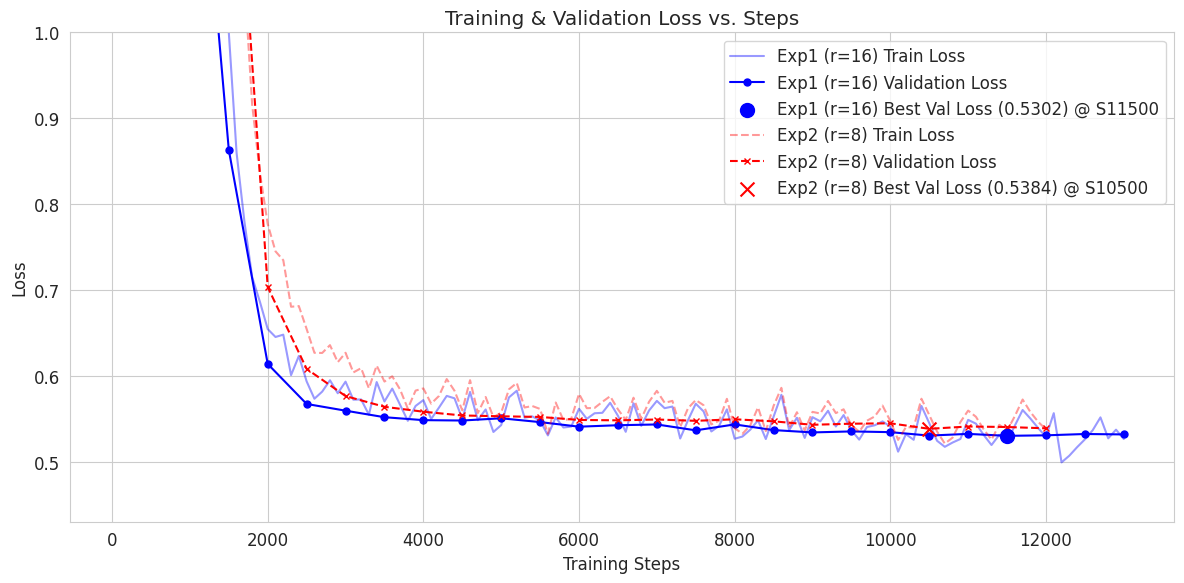

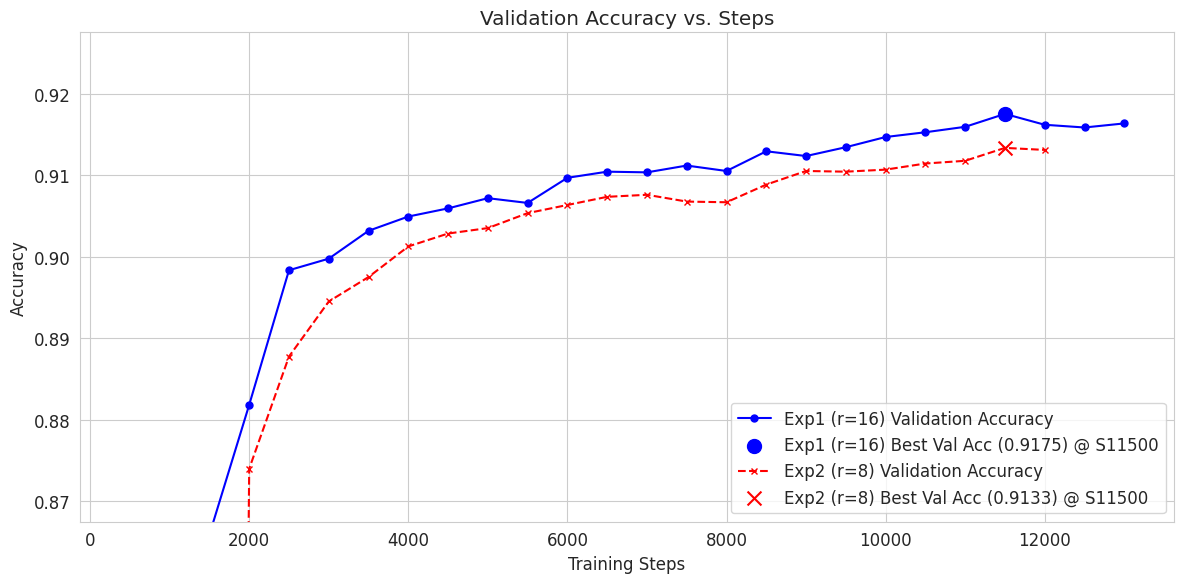

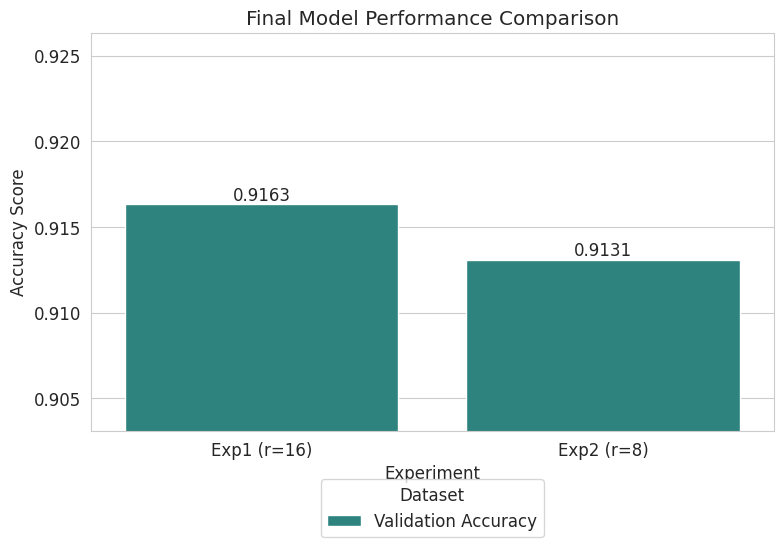

In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating Plots from Trainer Logs ---")

# --- Configuration - Define where the results are ---
output_dir_base = "results_experiments" # Base directory used during training
run_names = {
    "Exp1 (r=16)": "exp1_r16_loss_smoothing",
    "Exp2 (r=8)": "exp2_r8_loss_smoothing"
}
# Define where the AG News test set results were stored (from the evaluation cell)
# If the evaluation cell wasn't run or 'results' dict isn't available,
# you might need to manually add the values here.
# Example assuming 'results' dictionary exists from the previous evaluation cell:
# agnews_test_results = results
# Manual example:
agnews_test_results = {
     'Experiment 1 (r=16)': {'accuracy': 0.9141, 'precision': 0.9145, 'recall': 0.9141, 'f1': 0.9139},
     'Experiment 2 (r=8)': {'accuracy': 0.9101, 'precision': 0.9107, 'recall': 0.9101, 'f1': 0.9100}
}


# --- Function to Load and Process Logs ---
def load_and_process_log_history(run_name, base_dir):
    """Loads trainer_state.json and extracts training/eval logs."""
    if run_name == run_names["Exp1 (r=16)"]:
      log_file_path = os.path.join(base_dir, run_name, "final_model", "checkpoint-13000", "trainer_state.json")
    else:
      log_file_path = os.path.join(base_dir, run_name, "final_model", "checkpoint-12000", "trainer_state.json")
    print(f"Attempting to load log history from: {log_file_path}")

    if not os.path.exists(log_file_path):
        print(f"ERROR: trainer_state.json not found at {log_file_path}")
        return None, None, None

    try:
        with open(log_file_path, 'r') as f:
            state = json.load(f)
    except Exception as e:
        print(f"ERROR: Could not load or parse {log_file_path}: {e}")
        return None, None, None

    log_history = state.get("log_history", [])
    if not log_history:
        print(f"WARNING: No log history found in {log_file_path}")
        return None, None, None

    train_logs = []
    eval_logs = []
    final_val_metrics_from_log = {}

    for entry in log_history:
        log_entry = {'step': entry.get('step'), 'epoch': entry.get('epoch')}
        if 'loss' in entry: # Training step log
            log_entry['loss'] = entry.get('loss')
            log_entry['learning_rate'] = entry.get('learning_rate')
            if log_entry['loss'] is not None and log_entry['step'] is not None:
                 train_logs.append(log_entry)
        elif 'eval_loss' in entry: # Evaluation step log
            log_entry['eval_loss'] = entry.get('eval_loss')
            log_entry['eval_accuracy'] = entry.get('eval_accuracy')
            log_entry['eval_f1'] = entry.get('eval_f1')
            # Add other eval metrics if needed
            if log_entry['eval_loss'] is not None and log_entry['step'] is not None:
                eval_logs.append(log_entry)
                # Store the metrics from the latest eval step as the 'final' validation metrics
                # This assumes load_best_model_at_end=True worked and evaluation happened after loading
                final_val_metrics_from_log = {
                    'eval_loss': log_entry['eval_loss'],
                    'eval_accuracy': log_entry['eval_accuracy'],
                    'eval_f1': log_entry['eval_f1']
                }


    if not train_logs and not eval_logs:
        print(f"WARNING: No valid train or eval logs extracted from {log_file_path}")
        return None, None, None

    train_df = pd.DataFrame(train_logs) if train_logs else None
    eval_df = pd.DataFrame(eval_logs) if eval_logs else None

    print(f"Successfully processed logs for {run_name}. Found {len(train_logs)} train logs and {len(eval_logs)} eval logs.")
    return train_df, eval_df, final_val_metrics_from_log


# --- Load Data for All Experiments ---
experiment_data = {}
for display_name, run_folder in run_names.items():
    train_df, eval_df, final_val_metrics = load_and_process_log_history(run_folder, output_dir_base)
    if train_df is not None or eval_df is not None:
        experiment_data[display_name] = {
            'train': train_df,
            'eval': eval_df,
            'final_val_metrics': final_val_metrics,
            'agnews_test_metrics': agnews_test_results.get(display_name) # Get corresponding test metrics
        }

# --- Plotting ---
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})
colors = {'Exp1 (r=16)': 'blue', 'Exp2 (r=8)': 'red'}
markers = {'Exp1 (r=16)': 'o', 'Exp2 (r=8)': 'x'}
linestyles = {'Exp1 (r=16)': '-', 'Exp2 (r=8)': '--'}

# Plot 1: Training and Validation Loss Curves
plt.figure(figsize=(12, 6))
any_plot = False
for name, data in experiment_data.items():
    if data['train'] is not None:
        plt.plot(data['train']['step'], data['train']['loss'],
                 label=f'{name} Train Loss', color=colors[name], alpha=0.4, linestyle=linestyles[name])
        any_plot = True
    if data['eval'] is not None:
        plt.plot(data['eval']['step'], data['eval']['eval_loss'],
                 label=f'{name} Validation Loss', color=colors[name], marker=markers[name], markersize=5, linestyle=linestyles[name])
        # Mark best validation loss point from logs
        best_loss_idx = data['eval']['eval_loss'].idxmin()
        best_loss_step = data['eval'].loc[best_loss_idx, 'step']
        best_loss = data['eval'].loc[best_loss_idx, 'eval_loss']
        plt.scatter(best_loss_step, best_loss, color=colors[name], s=100, zorder=5, marker=markers[name],
                    label=f'{name} Best Val Loss ({best_loss:.4f}) @ S{int(best_loss_step)}')
        any_plot = True

if any_plot:
    plt.title('Training & Validation Loss vs. Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    # Auto-adjust ylim or set manually if needed
    min_eval_loss = min(d['eval']['eval_loss'].min() for d in experiment_data.values() if d['eval'] is not None and not d['eval'].empty)
    plt.ylim(bottom=max(0, min_eval_loss - 0.1), top=min(1.0, min_eval_loss + 0.5)) # Adjust ylim focus
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_base, "loss_curves_combined.png"))
    plt.show()
else:
    print("Skipping loss plot - no data loaded.")


# Plot 2: Validation Accuracy Curves
plt.figure(figsize=(12, 6))
any_plot = False
for name, data in experiment_data.items():
     if data['eval'] is not None:
        plt.plot(data['eval']['step'], data['eval']['eval_accuracy'],
                 label=f'{name} Validation Accuracy', color=colors[name], marker=markers[name], markersize=5, linestyle=linestyles[name])
        # Mark best validation accuracy point from logs
        best_acc_idx = data['eval']['eval_accuracy'].idxmax()
        best_acc_step = data['eval'].loc[best_acc_idx, 'step']
        best_acc = data['eval'].loc[best_acc_idx, 'eval_accuracy']
        plt.scatter(best_acc_step, best_acc, color=colors[name], s=100, zorder=5, marker=markers[name],
                    label=f'{name} Best Val Acc ({best_acc:.4f}) @ S{int(best_acc_step)}')
        any_plot = True

if any_plot:
    plt.title('Validation Accuracy vs. Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    max_acc = max(d['eval']['eval_accuracy'].max() for d in experiment_data.values() if d['eval'] is not None and not d['eval'].empty)
    plt.ylim(max(0.85, max_acc - 0.05) , min(1.0, max_acc + 0.01)) # Adjust ylim focus
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_base, "accuracy_curves_combined.png"))
    plt.show()
else:
    print("Skipping accuracy plot - no data loaded.")


# Plot 3: Final Performance Comparison (Bar Chart)
comparison_rows = []
for name, data in experiment_data.items():
    if data['final_val_metrics']:
        comparison_rows.append({
            'Experiment': name,
            'Metric': 'Validation Accuracy',
            'Score': data['final_val_metrics'].get('eval_accuracy', None)
        })
    if data['agnews_test_metrics']:
         comparison_rows.append({
            'Experiment': name,
            'Metric': 'AG News Test Accuracy',
            'Score': data['agnews_test_metrics'].get('accuracy', None)
        })
# Filter out rows with missing scores before creating DataFrame
comparison_rows = [row for row in comparison_rows if row['Score'] is not None]

if comparison_rows:
    comparison_df = pd.DataFrame(comparison_rows)
    plt.figure(figsize=(8, 6))
    barplot = sns.barplot(x='Experiment', y='Score', hue='Metric', data=comparison_df, palette='viridis')

    # Add text labels above bars
    for container in barplot.containers:
       try: # Add try-except for robustness if label generation fails
           barplot.bar_label(container, fmt='%.4f')
       except Exception as e:
           print(f"Could not add bar labels: {e}")


    plt.title('Final Model Performance Comparison')
    plt.ylabel('Accuracy Score')
    min_score = comparison_df['Score'].min()
    max_score = comparison_df['Score'].max()
    plt.ylim(max(0.85, min_score - 0.01), min(0.95, max_score + 0.01)) # Zoom in
    plt.legend(title='Dataset', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(os.path.join(output_dir_base, "final_comparison_accuracy.png"))
    plt.show()
else:
    print("Skipping final comparison plot - no data loaded or metrics missing.")

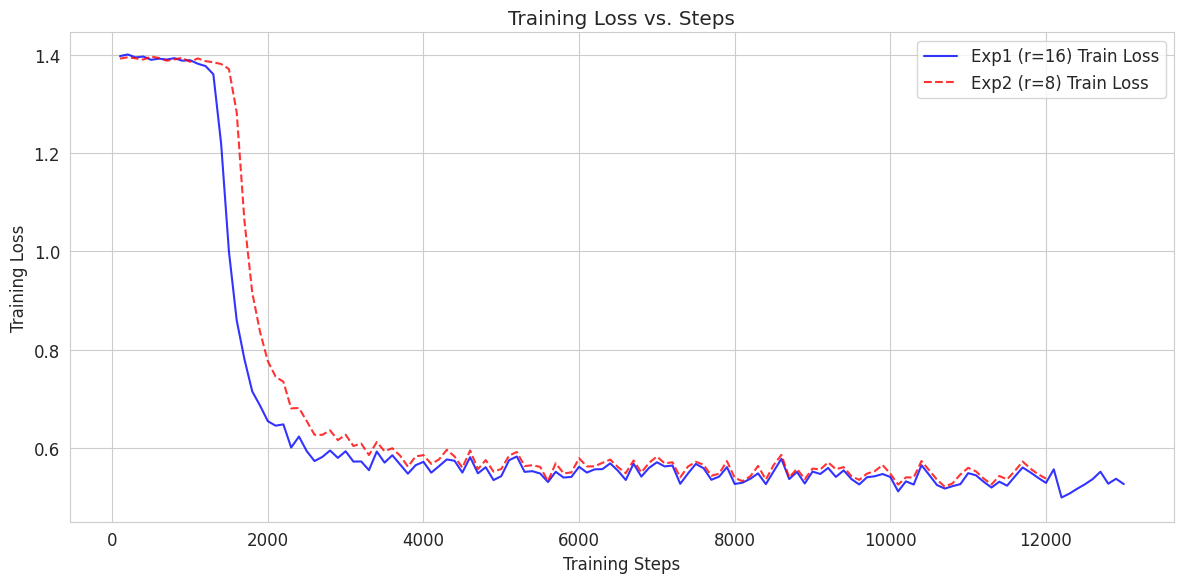

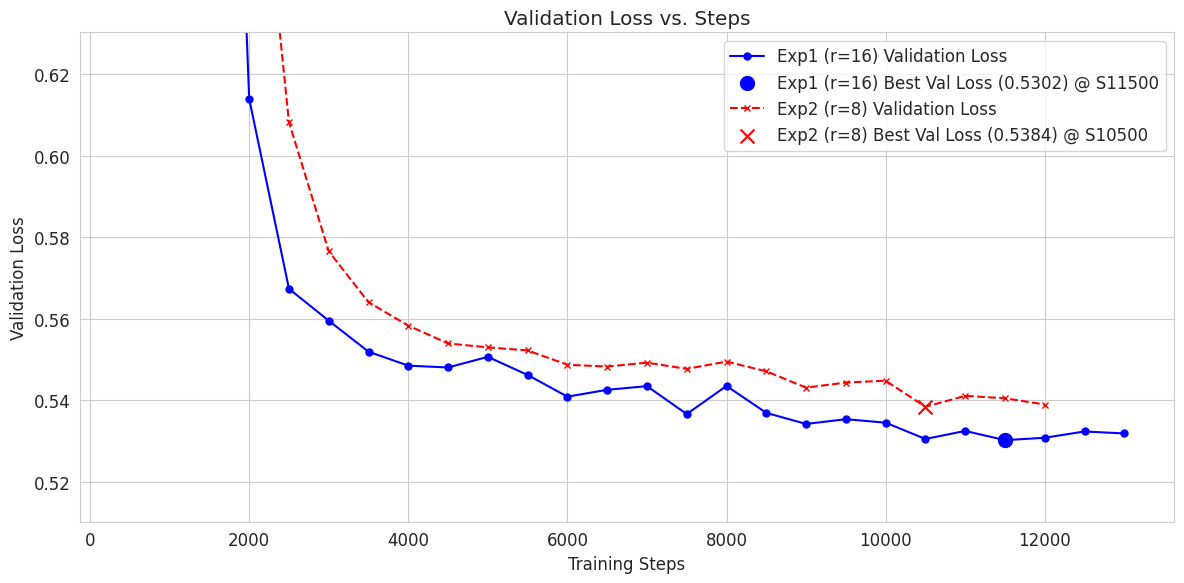

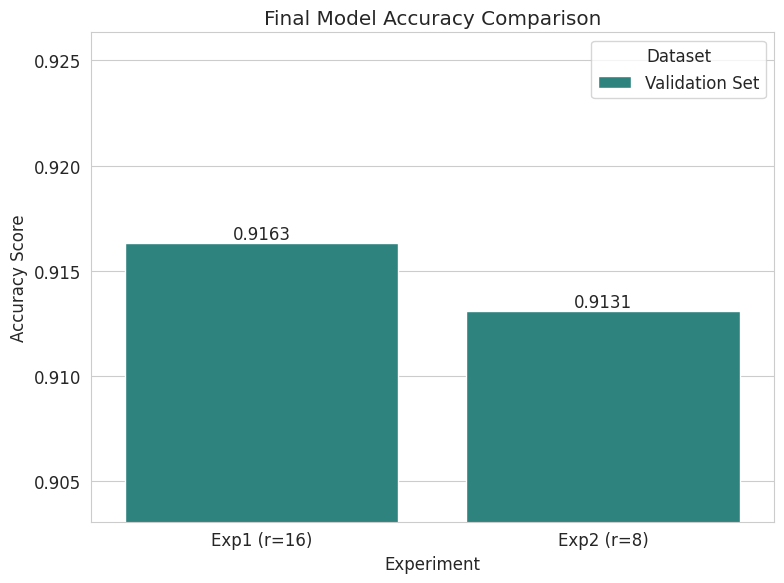

In [ ]:
# Ensure experiment_data dictionary is loaded from the previous cell
# Or re-run the log loading part from the previous cell if needed.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os # Make sure os is imported

# --- Plotting Setup ---
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})
output_dir_base = "results_experiments" # Make sure this is defined
colors = {'Exp1 (r=16)': 'blue', 'Exp2 (r=8)': 'red'}
markers = {'Exp1 (r=16)': 'o', 'Exp2 (r=8)': 'x'}
linestyles = {'Exp1 (r=16)': '-', 'Exp2 (r=8)': '--'}


# Plot 1: Training Loss ONLY
plt.figure(figsize=(12, 6))
any_plot = False
for name, data in experiment_data.items():
    if data['train'] is not None:
        plt.plot(data['train']['step'], data['train']['loss'],
                 label=f'{name} Train Loss', color=colors[name], alpha=0.8, linestyle=linestyles[name])
        any_plot = True

if any_plot:
    plt.title('Training Loss vs. Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Training Loss')
    plt.legend(loc='upper right')
    plt.ylim(bottom=0.45) # Adjust if needed
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_base, "training_loss_curves.png"))
    plt.show()
else:
    print("Skipping training loss plot - no data loaded.")


# Plot 2: Validation Loss ONLY
plt.figure(figsize=(12, 6))
any_plot = False
for name, data in experiment_data.items():
     if data['eval'] is not None:
        plt.plot(data['eval']['step'], data['eval']['eval_loss'],
                 label=f'{name} Validation Loss', color=colors[name], marker=markers[name], markersize=5, linestyle=linestyles[name])
        # Mark best validation loss point from logs
        best_loss_idx = data['eval']['eval_loss'].idxmin()
        best_loss_step = data['eval'].loc[best_loss_idx, 'step']
        best_loss = data['eval'].loc[best_loss_idx, 'eval_loss']
        plt.scatter(best_loss_step, best_loss, color=colors[name], s=100, zorder=5, marker=markers[name],
                    label=f'{name} Best Val Loss ({best_loss:.4f}) @ S{int(best_loss_step)}')
        any_plot = True

if any_plot:
    plt.title('Validation Loss vs. Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Validation Loss')
    plt.legend(loc='upper right')
    min_eval_loss = min(d['eval']['eval_loss'].min() for d in experiment_data.values() if d['eval'] is not None and not d['eval'].empty)
    plt.ylim(bottom=max(0.45, min_eval_loss - 0.02) , top=min(0.7, min_eval_loss + 0.1)) # Adjust ylim focus
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_base, "validation_loss_curves.png"))
    plt.show()
else:
    print("Skipping validation loss plot - no data loaded.")

# --- Code to Regenerate the Corrected Bar Chart ---
# Make sure agnews_test_results is correctly defined before this
agnews_test_results = {
     'Exp1 (r=16)': {'accuracy': 0.9141, 'precision': 0.9145, 'recall': 0.9141, 'f1': 0.9139},
     'Exp2 (r=8)': {'accuracy': 0.9101, 'precision': 0.9107, 'recall': 0.9101, 'f1': 0.9100}
}

comparison_rows = []
for name, data in experiment_data.items():
    # Use the metrics loaded from the trainer state for validation
    if data.get('final_val_metrics'):
        comparison_rows.append({
            'Experiment': name,
            'Dataset': 'Validation Set', # Use 'Dataset' for hue legend
            'Accuracy': data['final_val_metrics'].get('eval_accuracy', None)
        })
    # Use the results from the separate AG News test evaluation
    if data.get('agnews_test_metrics'):
         comparison_rows.append({
            'Experiment': name,
            'Dataset': 'AG News Test Set', # Use 'Dataset' for hue legend
            'Accuracy': data['agnews_test_metrics'].get('accuracy', None)
        })
# Filter out rows with missing scores before creating DataFrame
comparison_rows = [row for row in comparison_rows if row['Accuracy'] is not None]

if comparison_rows:
    comparison_df = pd.DataFrame(comparison_rows)
    plt.figure(figsize=(8, 6))
    barplot = sns.barplot(x='Experiment', y='Accuracy', hue='Dataset', data=comparison_df, palette='viridis') # Use Accuracy on y, Dataset for hue

    # Add text labels above bars
    for container in barplot.containers:
       try: # Add try-except for robustness if label generation fails
           barplot.bar_label(container, fmt='%.4f')
       except Exception as e:
           print(f"Could not add bar labels: {e}")

    plt.title('Final Model Accuracy Comparison')
    plt.ylabel('Accuracy Score')
    min_score = comparison_df['Accuracy'].min()
    max_score = comparison_df['Accuracy'].max()
    plt.ylim(max(0.88, min_score - 0.01), min(0.93, max_score + 0.01)) # Adjust zoom
    plt.legend(title='Dataset', loc='best') # Adjust legend position
    plt.tight_layout()#rect=[0, 0.05, 1, 1])
    plt.savefig(os.path.join(output_dir_base, "final_comparison_corrected.png"))
    plt.show()
else:
    print("Skipping final comparison plot - no data loaded or metrics missing.")

# DIFFERENT SECTION ---- Mostly Experimentation (Discarded)


In [ ]:

# ==============================================================================
# 12. Ensemble Prediction on Test Set
# ==============================================================================
# print("\\n===== Ensemble Prediction on Test Set =====") # Changed to single model
print("\\n===== Prediction on Test Set using Final Model =====")

# --- Load and Preprocess Test Data ---
test_dataset_unlabelled = None # Initialize to None
tokenized_test_dataset = None # Initialize to None
try:
    print(f"Attempting to load test data from: {os.path.abspath(TEST_DATA_PATH)}")
    loaded_test_data = pd.read_pickle(TEST_DATA_PATH) # Load first
    print(f"Successfully read pickle file. Type: {type(loaded_test_data)}")

    # Check if the loaded data is a DataFrame or a Dataset
    if isinstance(loaded_test_data, pd.DataFrame):
        print("Loaded data is a Pandas DataFrame. Converting to Hugging Face Dataset.")
        test_df_unlabelled = loaded_test_data
        test_df_unlabelled.info()
        if 'text' not in test_df_unlabelled.columns:
            raise ValueError("Test dataset DataFrame must contain a 'text' column.")
        # Ensure 'text' column is string type before conversion
        if not pd.api.types.is_string_dtype(test_df_unlabelled['text']):
             print("Warning: 'text' column is not string type. Attempting conversion.")
             test_df_unlabelled['text'] = test_df_unlabelled['text'].astype(str)
        test_dataset_unlabelled = Dataset.from_pandas(test_df_unlabelled)

    elif isinstance(loaded_test_data, Dataset):
        print("Loaded data is already a Hugging Face Dataset.")
        test_dataset_unlabelled = loaded_test_data
        if 'text' not in test_dataset_unlabelled.column_names:
             raise ValueError("Test dataset must contain a 'text' column.")
        print(test_dataset_unlabelled) # Print dataset structure

    else:
        raise TypeError(f"Loaded test data is of unexpected type: {type(loaded_test_data)}. Expected pandas.DataFrame or datasets.Dataset.")

    # # Simplification: Assume pickle contains DataFrame as intended by competition format
    # test_df_unlabelled = pd.read_pickle(TEST_DATA_PATH)
    # print(f"Successfully read pickle file. DataFrame info:")
    # if not isinstance(test_df_unlabelled, pd.DataFrame):
    #     raise TypeError(f"Loaded test data is not a pandas DataFrame. Type: {type(test_df_unlabelled)}")
    # test_df_unlabelled.info()
    # if 'text' not in test_df_unlabelled.columns:
    #     raise ValueError("Test dataset DataFrame must contain a 'text' column.")
    # # Ensure 'text' column is string type
    # if not pd.api.types.is_string_dtype(test_df_unlabelled['text']):
    #         print("Warning: 'text' column is not string type. Attempting conversion.")
    #         test_df_unlabelled['text'] = test_df_unlabelled['text'].astype(str)
    #
    # test_dataset_unlabelled = Dataset.from_pandas(test_df_unlabelled)


    print(f"Loaded unlabelled test data: {len(test_dataset_unlabelled)} samples")

    print("Preprocessing test data...")
    if 'text' not in test_dataset_unlabelled.column_names:
        raise ValueError("Cannot preprocess: 'text' column not found in the dataset.")

    # Tokenize and remove the original text column
    # Ensure the dataset is compatible with the model (columns expected by forward pass)
    tokenized_test_dataset = test_dataset_unlabelled.map(
        preprocess_function,
        batched=True,
        remove_columns=['text'] # Explicitly remove 'text' after tokenization
    )
    print("Test data preprocessing complete.")
    print("Columns after tokenization:", tokenized_test_dataset.column_names)
    # Ensure necessary columns are present for the model
    model_input_columns = tokenizer.model_input_names # e.g., ['input_ids', 'attention_mask']
    missing_cols = [col for col in model_input_columns if col not in tokenized_test_dataset.column_names]
    if missing_cols:
        raise ValueError(f"Tokenized dataset is missing required model input columns: {missing_cols}")
    # Keep only the columns the model needs
    tokenized_test_dataset.set_format(type="torch", columns=model_input_columns)


except FileNotFoundError:
    print(f"Error: Test data file not found at the expected path: {os.path.abspath(TEST_DATA_PATH)}")
    tokenized_test_dataset = None # Ensure it's None
except (pickle.UnpicklingError, ValueError, TypeError, KeyError, AttributeError) as load_err:
    print(f"Error reading, converting, or preprocessing the test data file '{TEST_DATA_PATH}': {load_err}")
    import traceback
    traceback.print_exc()
    tokenized_test_dataset = None # Ensure it's None
except Exception as e:
    print(f"An unexpected error occurred during test data loading or processing: {e}")
    import traceback
    traceback.print_exc()
    tokenized_test_dataset = None # Ensure it's None

# --- Run Inference ---
# Check if tokenized_test_dataset was successfully created
# if tokenized_test_dataset and final_model_path: # Old check
if tokenized_test_dataset is not None and final_model_path:
    print("\nLoading final model for inference...")
    try:
        # Load the base model architecture
        base_model_for_inference = RobertaForSequenceClassification.from_pretrained(
            BASE_MODEL,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
        )
        # Apply the saved PEFT adapters
        # inference_model = PeftModel.from_pretrained(base_model_for_inference, model_path)
        inference_model = PeftModel.from_pretrained(base_model_for_inference, final_model_path)
        inference_model.to(DEVICE) # Move loaded model to GPU/CPU

        # Get predictions (logits) from this model
        # fold_logits = get_model_predictions(inference_model, tokenized_test_dataset, EVAL_BATCH_SIZE, data_collator)
        # ensemble_logits.append(fold_logits)
        final_logits = get_model_predictions(inference_model, tokenized_test_dataset, EVAL_BATCH_SIZE, data_collator)

        # Clean up memory
        del base_model_for_inference, inference_model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        # print(f"Error loading or predicting with model from {model_path}: {e}")
        # print("Skipping this model for the ensemble.")
        print(f"Error loading or predicting with the final model from {final_model_path}: {e}")
        final_logits = None # Ensure it's None if loading failed

    # if ensemble_logits:
    if final_logits is not None:
        # Average the logits across all successfully loaded models
        # print("Averaging logits...")
        # stacked_logits = torch.stack(ensemble_logits) # Shape: [num_models, num_samples, num_classes]
        # avg_logits = stacked_logits.mean(dim=0)      # Shape: [num_samples, num_classes]
        avg_logits = final_logits # Use the logits from the single model

        # Get final predictions by taking argmax of averaged logits
        final_predictions = torch.argmax(avg_logits, dim=-1).numpy() # Shape: [num_samples]

        # Create submission file
        print("Creating submission file...")
        submission_df = pd.DataFrame({
            'ID': range(len(final_predictions)), # Assuming IDs are 0-based sequential
            'Label': final_predictions
        })

        # submission_path = os.path.join(OUTPUT_DIR, "ensemble_submission.csv")
        submission_path = os.path.join(OUTPUT_DIR, "submission.csv") # Simpler name
        submission_df.to_csv(submission_path, index=False)
        # print(f"Ensemble predictions saved to: {submission_path}")
        print(f"Predictions saved to: {submission_path}")
    else:
        # print("No models were successfully loaded for ensemble prediction.")
        print("Prediction failed due to error loading or running the final model.")

# elif not final_model_paths:
elif not final_model_path:
    print("Skipping test set prediction: No final trained model found.")
else:
     print("Skipping test set prediction: Could not load test data.")


print("\nScript finished.")

\n===== Prediction on Test Set using Final Model =====
Attempting to load test data from: /content/test_unlabelled.pkl
Successfully read pickle file. Type: <class 'datasets.arrow_dataset.Dataset'>
Loaded data is already a Hugging Face Dataset.
Dataset({
    features: ['text'],
    num_rows: 8000
})
Loaded unlabelled test data: 8000 samples
Preprocessing test data...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Test data preprocessing complete.
Columns after tokenization: ['input_ids', 'attention_mask']

Loading final model for inference...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running inference on 8000 samples...


Inference:   0%|          | 0/63 [00:00<?, ?it/s]

Inference loop complete.
Creating submission file...
Predictions saved to: results_single_model/submission.csv

Script finished.


## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

> Add blockquote



In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# Enhanced PEFT Config
peft_config = LoraConfig(
    r=8,  # Higher rank for better expressivity
    lora_alpha=32,  # Higher alpha for stronger adaptation
    lora_dropout=0.1,
    bias='none',
    target_modules=["query", "key", "value", "output.dense"],  # Target all attention components and output
    task_type="SEQ_CLS",
    modules_to_save=None  # Don't include classifier in trainable params
)

In [ ]:
peft_model = get_peft_model(model, peft_config)
for param in peft_model.base_model.model.classifier.parameters():
    param.requires_grad = False
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [ ]:
# print("Trainable parameters:")
# for name, param in peft_model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 958,464 || all params: 126,200,840 || trainable%: 0.7595


## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate multiple metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Setup Training args
# Better Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    logging_steps=100,
    learning_rate=1e-4,
    num_train_epochs=2,
    max_steps=-1,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True},
    fp16=True,
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training with Single Model

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

peft_model.save_pretrained(os.path.join(output_dir, "best_model"))
print("Best model saved to", os.path.join(output_dir, "best_model"))

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refe

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

NameError: name 'evaluate_model' is not defined

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
# def classify(model, tokenizer, text):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
#     output = model(**inputs)

#     prediction = output.logits.argmax(dim=-1).item()

#     print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
#     return id2label[prediction]

In [ ]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:03<00:00, 24.33it/s]

Evaluation Metric: {'accuracy': 0.2390625}


In [ ]:
# Function to make predictions with ensemble
def ensemble_predict(models, dataset, batch_size=8, data_collator=None):
    all_preds = []

    for model in models:
        # Get predictions from this model
        preds = evaluate_model(model, dataset, False, batch_size, data_collator)
        all_preds.append(preds.numpy())

    # Stack predictions and take majority vote
    stacked_preds = np.stack(all_preds)
    ensemble_preds = np.zeros(stacked_preds.shape[1], dtype=np.int64)

    # For each sample, count votes for each class
    for i in range(stacked_preds.shape[1]):
        counts = np.bincount(stacked_preds[:, i])
        ensemble_preds[i] = np.argmax(counts)

    return ensemble_preds

# Uncomment to use ensemble for final prediction
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

ensemble_preds = ensemble_predict(ensemble_models, test_dataset, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(ensemble_preds)),
    'Label': ensemble_preds
})
df_output.to_csv(os.path.join(output_dir, "ensemble_output.csv"), index=False)
print("Ensemble inference complete. Predictions saved to ensemble_output.csv")

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [00:31<00:00, 31.98it/s]

Ensemble inference complete. Predictions saved to ensemble_output.csv


### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
# unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
# test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
# unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
# Run inference and save predictions
# preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
# df_output = pd.DataFrame({
#     'ID': range(len(preds)),
#     'Label': preds.numpy()  # or preds.tolist()
# })
# df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
# print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:41<00:00, 24.09it/s]

Inference complete. Predictions saved to inference_output.csv
